In [1]:
import polars as pl
import torch
from sklearn.metrics import classification_report
from sklearn.neighbors import NearestNeighbors
import numpy as np
from amaretto_mlp import *
from utils_b import *
from autoencoder import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

# 1. Data & Models Setup

## 1.1. Load data & model

In [2]:
pl.Config.set_tbl_cols(132) 

polars.config.Config

In [3]:
df = pl.read_parquet("amaretto_transformed_scaled.pq")
df_train, df_val, df_test = split_data(df)
columns_to_drop = ['id', 'Anomaly', 'Anomaly_bin', 'Originator', 'datetime']

target_column = 'Anomaly'
y_train = df_train.select(target_column).to_numpy().flatten()
df_train = df_train.drop(columns_to_drop)
X_train = df_train.to_numpy()
y_val = df_val.select(target_column).to_numpy().flatten()
X_val = df_val.drop(columns_to_drop).to_numpy()
y_test = df_test.select(target_column).to_numpy().flatten()
X_test = df_test.drop(columns_to_drop).to_numpy()

train_dataset = AmarettoDataset(X_train, y_train)
val_dataset = AmarettoDataset(X_val, y_val)
test_dataset = AmarettoDataset(X_test, y_test)
feature_names = df_train.columns
print(X_train.shape)
print(X_test.shape)

(24451934, 125)
(2765755, 125)


In [4]:
print(len(feature_names))

125


In [5]:
train_loader = DataLoader(train_dataset, batch_size=256, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=256, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=256, num_workers=2)
input_dim = X_train.shape[1]
df_train, df_val, df_test = split_data(df)
print(len(train_loader))

95516


In [6]:
model = CombinedModel(input_dim=X_train.shape[1], hidden_layers=[64, 32], latent_dim=16, num_classes=6)
model.load_state_dict(torch.load("model_combined.pth"))
print(model)

CombinedModel(
  (encoder): Encoder(
    (network): Sequential(
      (0): Linear(in_features=125, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=32, bias=True)
      (3): Tanh()
      (4): Linear(in_features=32, out_features=16, bias=True)
    )
  )
  (decoder): Decoder(
    (network): Sequential(
      (0): Linear(in_features=16, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=64, bias=True)
      (3): Tanh()
      (4): Linear(in_features=64, out_features=125, bias=True)
    )
  )
  (classifier): Classifier(
    (network): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=6, bias=True)
    )
  )
)


## 1.2. Obtain laten space and predictions for train and test data

In [7]:
model.eval()
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
with torch.no_grad():
    _, y_pred_train, z_train = model(X_train_tensor)
    y_pred_train = torch.argmax(y_pred_train, dim=1)
y_pred_train = y_pred_train.cpu().detach().numpy()
print(y_pred_train.shape)
z_train = z_train.cpu().numpy()
print(z_train.shape)

(24451934,)
(24451934, 16)


In [8]:
model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
with torch.no_grad():
    _, y_pred_test, z_test = model(X_test_tensor)
    y_pred_test = torch.argmax(y_pred_test, dim=1)
y_pred_test = y_pred_test.cpu().detach().numpy()
print(y_pred_test.shape)
z_test = z_test.cpu().numpy()
print(z_test.shape)

(2765755,)
(2765755, 16)


In [9]:
df_test = df_test.with_columns(pl.Series("Model Prediction", y_pred_test))
df_test = df_test.select(["Model Prediction", *df_test.columns[:-1]])  
df_test = df_test.with_row_index(name="index")
df_test

shape: (2_765_755, 132)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ ind ┆ Mod ┆ id  ┆ dat ┆ Ori ┆ Ano ┆ Ano ┆ amo ┆ Inp ┆ Inp ┆ Mar ┆ Mar ┆ Mar ┆ Mar ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Cur ┆ Cur ┆ day ┆ day ┆ hou ┆ min ┆ is_ ┆ ori ┆ ori ┆ ori ┆ ori ┆ ori ┆ mar ┆ mar ┆ mar ┆ mar ┆ mar ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ ori ┆ mar ┆ pro ┆ pro ┆ day ┆ day ┆ day ┆ day ┆ hou ┆ hou ┆ min ┆ min ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ cum ┆ cum ┆ cum ┆ cum ┆ cum ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur │
│ ex  ┆ el  ┆ --- ┆ eti ┆ gin ┆ mal ┆ mal ┆ unt ┆ utO ┆ utO ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ ren ┆ ren ┆ _of ┆ _of ┆ r   ┆ ute ┆ rou ┆ gin ┆ gin ┆ gin ┆ gin ┆ gin ┆ ket ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ gin ┆ ket ┆ duc ┆ duc ┆ _of ┆ _of ┆ _of ┆ _of ┆ r_s ┆ r_c ┆ ute ┆ ute ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ cou ┆ cou ┆ cou ┆ cou ┆ cou ┆ utO ┆ ket ┆ duc ┆ duc ┆ ren │
│ --- ┆ Pre ┆ u32 ┆ me  ┆ ato ┆ y   ┆ y_b ┆ _lo ┆ utp ┆ utp ┆ _1  ┆ _2  ┆ _3  ┆ _4  ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ cy_ ┆ cy_ ┆ _we ┆ _mo ┆ --- ┆ --- ┆ nde ┆ ato ┆ ato ┆ ato ┆ ato ┆ ato ┆ _in ┆ _in ┆ _in ┆ _in ┆ _in ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ ato ┆ _in ┆ t_t ┆ t_c ┆ _we ┆ _we ┆ _mo ┆ _mo ┆ in  ┆ os  ┆ _si ┆ _co ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ utp ┆ _fr ┆ t   ┆ t   ┆ cy_ │
│ u32 ┆ dic ┆     ┆ --- ┆ r   ┆ --- ┆ in  ┆ g   ┆ ut_ ┆ ut_ ┆ --- ┆ --- ┆ --- ┆ --- ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Cla ┆ Cla ┆ Cla ┆ Cla ┆ 1   ┆ 2   ┆ ek  ┆ nth ┆ i8  ┆ i8  ┆ d   ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ dex ┆ dex ┆ dex ┆ dex ┆ dex ┆ ype ┆ ype ┆ ype ┆ ype ┆ ype ┆ las ┆ las ┆ las ┆ las ┆ las ┆ r_i ┆ dex ┆ ype ┆ las ┆ ek_ ┆ ek_ ┆ nth ┆ nth ┆ --- ┆ --- ┆ n   ┆ s   ┆ ean ┆ ean ┆ ean ┆ ean ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ ean ┆ ean ┆ ean ┆ ean ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur ┆ ut_ ┆ eq_ ┆ Typ ┆ Cla ┆ fre │
│     

In [10]:
df_train = df_train.with_columns(pl.Series("Model Prediction", y_pred_train))
df_train = df_train.select(["Model Prediction", *df_train.columns[:-1]])  
df_train = df_train.with_row_index(name="index")
df_train

shape: (24_451_934, 132)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ ind ┆ Mod ┆ id  ┆ dat ┆ Ori ┆ Ano ┆ Ano ┆ amo ┆ Inp ┆ Inp ┆ Mar ┆ Mar ┆ Mar ┆ Mar ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Cur ┆ Cur ┆ day ┆ day ┆ hou ┆ min ┆ is_ ┆ ori ┆ ori ┆ ori ┆ ori ┆ ori ┆ mar ┆ mar ┆ mar ┆ mar ┆ mar ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ ori ┆ mar ┆ pro ┆ pro ┆ day ┆ day ┆ day ┆ day ┆ hou ┆ hou ┆ min ┆ min ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ cum ┆ cum ┆ cum ┆ cum ┆ cum ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur │
│ ex  ┆ el  ┆ --- ┆ eti ┆ gin ┆ mal ┆ mal ┆ unt ┆ utO ┆ utO ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ ren ┆ ren ┆ _of ┆ _of ┆ r   ┆ ute ┆ rou ┆ gin ┆ gin ┆ gin ┆ gin ┆ gin ┆ ket ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ gin ┆ ket ┆ duc ┆ duc ┆ _of ┆ _of ┆ _of ┆ _of ┆ r_s ┆ r_c ┆ ute ┆ ute ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ cou ┆ cou ┆ cou ┆ cou ┆ cou ┆ utO ┆ ket ┆ duc ┆ duc ┆ ren │
│ --- ┆ Pre ┆ u32 ┆ me  ┆ ato ┆ y   ┆ y_b ┆ _lo ┆ utp ┆ utp ┆ _1  ┆ _2  ┆ _3  ┆ _4  ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ cy_ ┆ cy_ ┆ _we ┆ _mo ┆ --- ┆ --- ┆ nde ┆ ato ┆ ato ┆ ato ┆ ato ┆ ato ┆ _in ┆ _in ┆ _in ┆ _in ┆ _in ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ ato ┆ _in ┆ t_t ┆ t_c ┆ _we ┆ _we ┆ _mo ┆ _mo ┆ in  ┆ os  ┆ _si ┆ _co ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ utp ┆ _fr ┆ t   ┆ t   ┆ cy_ │
│ u32 ┆ dic ┆     ┆ --- ┆ r   ┆ --- ┆ in  ┆ g   ┆ ut_ ┆ ut_ ┆ --- ┆ --- ┆ --- ┆ --- ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Cla ┆ Cla ┆ Cla ┆ Cla ┆ 1   ┆ 2   ┆ ek  ┆ nth ┆ i8  ┆ i8  ┆ d   ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ dex ┆ dex ┆ dex ┆ dex ┆ dex ┆ ype ┆ ype ┆ ype ┆ ype ┆ ype ┆ las ┆ las ┆ las ┆ las ┆ las ┆ r_i ┆ dex ┆ ype ┆ las ┆ ek_ ┆ ek_ ┆ nth ┆ nth ┆ --- ┆ --- ┆ n   ┆ s   ┆ ean ┆ ean ┆ ean ┆ ean ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ ean ┆ ean ┆ ean ┆ ean ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur ┆ ut_ ┆ eq_ ┆ Typ ┆ Cla ┆ fre │
│    

## 1.3. Evaluation results

In [11]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2759074
           1       0.24      0.93      0.38       576
           2       0.28      0.99      0.43       257
           3       0.69      0.92      0.79      1175
           4       0.48      0.87      0.62      2228
           5       0.46      0.39      0.42      2445

    accuracy                           1.00   2765755
   macro avg       0.53      0.85      0.61   2765755
weighted avg       1.00      1.00      1.00   2765755



## 1.4. Define k-NN Search Method


In [12]:
knn = NearestNeighbors(n_neighbors=9, algorithm='auto', metric='euclidean')
knn.fit(z_train)

NearestNeighbors(metric='euclidean', n_neighbors=9)

# 2. Analysis for Each Anomaly Type

In [13]:
mask_correct_preds = (y_test[y_test != 0] == y_pred_test[y_test != 0])
mask_wrong_preds = (y_test[y_test != 0] != y_pred_test[y_test != 0])
print(mask_correct_preds.sum())
print(mask_wrong_preds.sum())

4768
1913


In [14]:
df_correct_preds = df_test.filter((pl.col("Anomaly") != 0))
df_correct_preds = df_correct_preds.filter(mask_correct_preds)
df_wrong_preds = df_test.filter((pl.col("Anomaly") != 0))
df_wrong_preds = df_wrong_preds.filter(mask_wrong_preds)
print(df_correct_preds.height)
print(df_wrong_preds.height)

4768
1913


## 2.1. Small but highly frequent transactions generated within a short timeframe:
A pattern that contains multiple transactions below applicable reporting thresholds.  
Selected indexes from testing set: 38329, 62415

### 2.1.1. Correct prediction:

In [10]:
x_38329 = torch.tensor(X_test[38329], dtype=torch.float32)
x_38329[:6]

tensor([-1.4487,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000])

In [16]:
model.encoder.eval()
test_transaction_latent = model.encoder(x_38329)
test_transaction_latent = test_transaction_latent.cpu().detach().numpy()
test_transaction_latent = test_transaction_latent.reshape(1, -1)
test_transaction_latent.shape

(1, 16)

In [17]:
k = 9
distances, indices = knn.kneighbors(test_transaction_latent, n_neighbors=k)
print(indices)
print(distances)

[[15331650  5746304  4658090 14831910  4618398  4653400  4747816  5627063
   6337860]]
[[0.76601273 1.0838995  1.08571053 1.10980785 1.14570367 1.15599835
  1.1784091  1.19861209 1.22553897]]


In [18]:
df_correct_preds.filter(pl.col("index") == 38329)

shape: (1, 132)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ ind ┆ Mod ┆ id  ┆ dat ┆ Ori ┆ Ano ┆ Ano ┆ amo ┆ Inp ┆ Inp ┆ Mar ┆ Mar ┆ Mar ┆ Mar ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Cur ┆ Cur ┆ day ┆ day ┆ hou ┆ min ┆ is_ ┆ ori ┆ ori ┆ ori ┆ ori ┆ ori ┆ mar ┆ mar ┆ mar ┆ mar ┆ mar ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ ori ┆ mar ┆ pro ┆ pro ┆ day ┆ day ┆ day ┆ day ┆ hou ┆ hou ┆ min ┆ min ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ cum ┆ cum ┆ cum ┆ cum ┆ cum ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur │
│ ex  ┆ el  ┆ --- ┆ eti ┆ gin ┆ mal ┆ mal ┆ unt ┆ utO ┆ utO ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ ren ┆ ren ┆ _of ┆ _of ┆ r   ┆ ute ┆ rou ┆ gin ┆ gin ┆ gin ┆ gin ┆ gin ┆ ket ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ gin ┆ ket ┆ duc ┆ duc ┆ _of ┆ _of ┆ _of ┆ _of ┆ r_s ┆ r_c ┆ ute ┆ ute ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ cou ┆ cou ┆ cou ┆ cou ┆ cou ┆ utO ┆ ket ┆ duc ┆ duc ┆ ren │
│ --- ┆ Pre ┆ u32 ┆ me  ┆ ato ┆ y   ┆ y_b ┆ _lo ┆ utp ┆ utp ┆ _1  ┆ _2  ┆ _3  ┆ _4  ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ cy_ ┆ cy_ ┆ _we ┆ _mo ┆ --- ┆ --- ┆ nde ┆ ato ┆ ato ┆ ato ┆ ato ┆ ato ┆ _in ┆ _in ┆ _in ┆ _in ┆ _in ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ ato ┆ _in ┆ t_t ┆ t_c ┆ _we ┆ _we ┆ _mo ┆ _mo ┆ in  ┆ os  ┆ _si ┆ _co ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ utp ┆ _fr ┆ t   ┆ t   ┆ cy_ │
│ u32 ┆ dic ┆     ┆ --- ┆ r   ┆ --- ┆ in  ┆ g   ┆ ut_ ┆ ut_ ┆ --- ┆ --- ┆ --- ┆ --- ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Cla ┆ Cla ┆ Cla ┆ Cla ┆ 1   ┆ 2   ┆ ek  ┆ nth ┆ i8  ┆ i8  ┆ d   ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ dex ┆ dex ┆ dex ┆ dex ┆ dex ┆ ype ┆ ype ┆ ype ┆ ype ┆ ype ┆ las ┆ las ┆ las ┆ las ┆ las ┆ r_i ┆ dex ┆ ype ┆ las ┆ ek_ ┆ ek_ ┆ nth ┆ nth ┆ --- ┆ --- ┆ n   ┆ s   ┆ ean ┆ ean ┆ ean ┆ ean ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ ean ┆ ean ┆ ean ┆ ean ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur ┆ ut_ ┆ eq_ ┆ Typ ┆ Cla ┆ fre │
│     ┆ tio ┆ 

In [19]:
df_train[indices.flatten().tolist()]

shape: (9, 132)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ ind ┆ Mod ┆ id  ┆ dat ┆ Ori ┆ Ano ┆ Ano ┆ amo ┆ Inp ┆ Inp ┆ Mar ┆ Mar ┆ Mar ┆ Mar ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Cur ┆ Cur ┆ day ┆ day ┆ hou ┆ min ┆ is_ ┆ ori ┆ ori ┆ ori ┆ ori ┆ ori ┆ mar ┆ mar ┆ mar ┆ mar ┆ mar ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ ori ┆ mar ┆ pro ┆ pro ┆ day ┆ day ┆ day ┆ day ┆ hou ┆ hou ┆ min ┆ min ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ cum ┆ cum ┆ cum ┆ cum ┆ cum ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur │
│ ex  ┆ el  ┆ --- ┆ eti ┆ gin ┆ mal ┆ mal ┆ unt ┆ utO ┆ utO ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ ren ┆ ren ┆ _of ┆ _of ┆ r   ┆ ute ┆ rou ┆ gin ┆ gin ┆ gin ┆ gin ┆ gin ┆ ket ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ gin ┆ ket ┆ duc ┆ duc ┆ _of ┆ _of ┆ _of ┆ _of ┆ r_s ┆ r_c ┆ ute ┆ ute ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ cou ┆ cou ┆ cou ┆ cou ┆ cou ┆ utO ┆ ket ┆ duc ┆ duc ┆ ren │
│ --- ┆ Pre ┆ u32 ┆ me  ┆ ato ┆ y   ┆ y_b ┆ _lo ┆ utp ┆ utp ┆ _1  ┆ _2  ┆ _3  ┆ _4  ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ cy_ ┆ cy_ ┆ _we ┆ _mo ┆ --- ┆ --- ┆ nde ┆ ato ┆ ato ┆ ato ┆ ato ┆ ato ┆ _in ┆ _in ┆ _in ┆ _in ┆ _in ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ ato ┆ _in ┆ t_t ┆ t_c ┆ _we ┆ _we ┆ _mo ┆ _mo ┆ in  ┆ os  ┆ _si ┆ _co ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ utp ┆ _fr ┆ t   ┆ t   ┆ cy_ │
│ u32 ┆ dic ┆     ┆ --- ┆ r   ┆ --- ┆ in  ┆ g   ┆ ut_ ┆ ut_ ┆ --- ┆ --- ┆ --- ┆ --- ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Cla ┆ Cla ┆ Cla ┆ Cla ┆ 1   ┆ 2   ┆ ek  ┆ nth ┆ i8  ┆ i8  ┆ d   ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ dex ┆ dex ┆ dex ┆ dex ┆ dex ┆ ype ┆ ype ┆ ype ┆ ype ┆ ype ┆ las ┆ las ┆ las ┆ las ┆ las ┆ r_i ┆ dex ┆ ype ┆ las ┆ ek_ ┆ ek_ ┆ nth ┆ nth ┆ --- ┆ --- ┆ n   ┆ s   ┆ ean ┆ ean ┆ ean ┆ ean ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ ean ┆ ean ┆ ean ┆ ean ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur ┆ ut_ ┆ eq_ ┆ Typ ┆ Cla ┆ fre │
│     ┆ tio ┆ 

In [20]:
print(z_train[indices.flatten().tolist()][1:3])

[[-1.9108541  -0.2559423  -0.49183255 -3.5275347  -0.878192   -0.5947329
  -0.40787393  2.1667094  -2.2090037  -0.6234193  -2.2077599   1.5936036
   0.5121195   0.7161606  -0.76077384 -3.0988145 ]
 [-2.4169302  -0.69858044 -0.21707273 -3.929904   -0.58289784 -0.2279321
  -0.92739505  2.019814   -1.7268871  -0.6007668  -1.991197    0.9367852
   0.8320989   0.69550276 -0.8708064  -2.4754653 ]]


In [21]:
print(z_test[38329])

[-1.8543928  -0.39676404 -0.3398804  -3.7538128  -0.46145567 -0.41433507
 -1.0469179   2.279829   -1.8658466  -0.6115927  -2.1304078   1.3584336
  0.635863    0.39090097 -0.5040114  -2.8091183 ]


In [21]:
X_train_shap, _, _ = sample_data(X_train, y_train, n_samples=3000, anomaly_ratio=0.3, random_seed=42)

[ 4837  2078  9758 26386 24820]


Using 2998 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

SHAP values shape: (1, 125, 6)


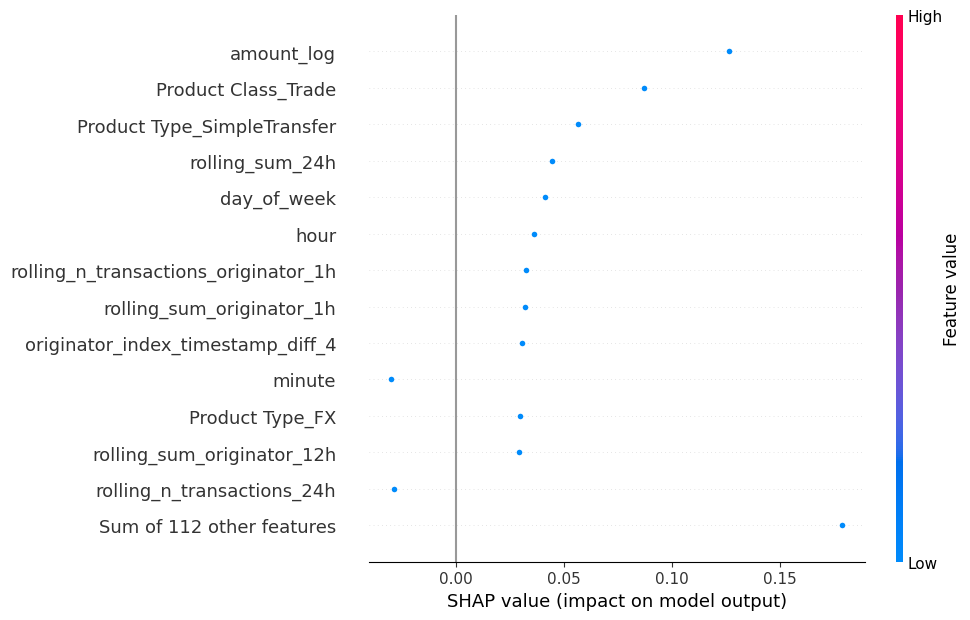

<Figure size 640x480 with 0 Axes>

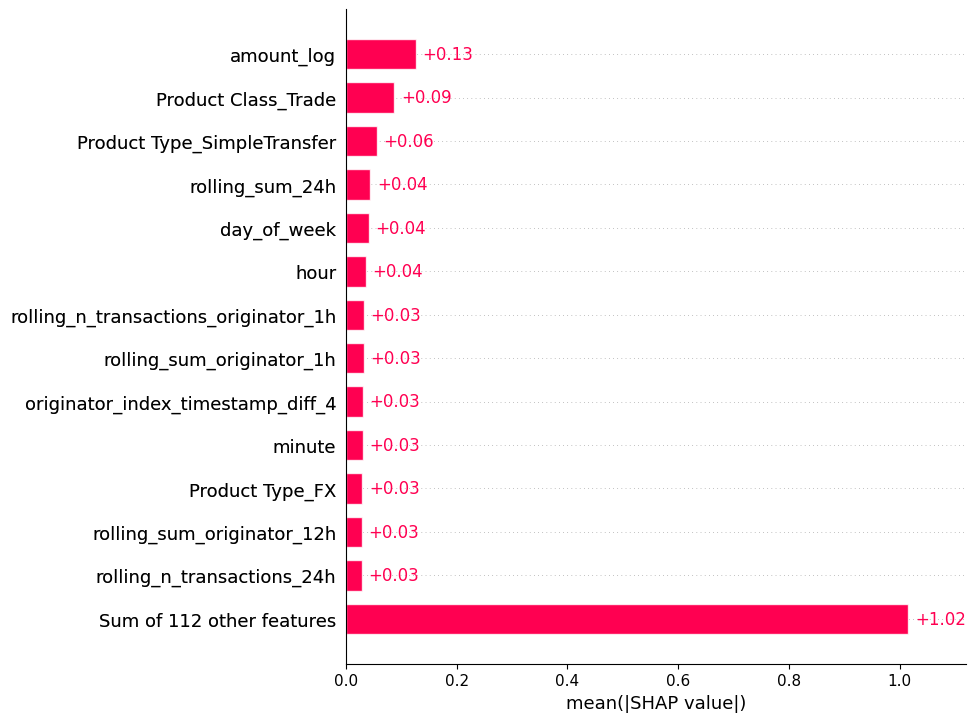

Saved SHAP plots for class 1 to output/shap_plots/
SHAP explanations generated and saved.


In [36]:
 get_shap_explanations_mlp_class(model, X_train_shap, X_test[38329].reshape(1, -1), feature_names, filename='figs/shap_plots/shap_amaretto_GM')

### 2.1.2. Incorrect prediction:

In [22]:
df_test.filter((pl.col("Anomaly") == 1) & (pl.col("Model Prediction") != 1))

shape: (41, 132)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ ind ┆ Mod ┆ id  ┆ dat ┆ Ori ┆ Ano ┆ Ano ┆ amo ┆ Inp ┆ Inp ┆ Mar ┆ Mar ┆ Mar ┆ Mar ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Cur ┆ Cur ┆ day ┆ day ┆ hou ┆ min ┆ is_ ┆ ori ┆ ori ┆ ori ┆ ori ┆ ori ┆ mar ┆ mar ┆ mar ┆ mar ┆ mar ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ ori ┆ mar ┆ pro ┆ pro ┆ day ┆ day ┆ day ┆ day ┆ hou ┆ hou ┆ min ┆ min ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ cum ┆ cum ┆ cum ┆ cum ┆ cum ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur │
│ ex  ┆ el  ┆ --- ┆ eti ┆ gin ┆ mal ┆ mal ┆ unt ┆ utO ┆ utO ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ ren ┆ ren ┆ _of ┆ _of ┆ r   ┆ ute ┆ rou ┆ gin ┆ gin ┆ gin ┆ gin ┆ gin ┆ ket ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ gin ┆ ket ┆ duc ┆ duc ┆ _of ┆ _of ┆ _of ┆ _of ┆ r_s ┆ r_c ┆ ute ┆ ute ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ cou ┆ cou ┆ cou ┆ cou ┆ cou ┆ utO ┆ ket ┆ duc ┆ duc ┆ ren │
│ --- ┆ Pre ┆ u32 ┆ me  ┆ ato ┆ y   ┆ y_b ┆ _lo ┆ utp ┆ utp ┆ _1  ┆ _2  ┆ _3  ┆ _4  ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ cy_ ┆ cy_ ┆ _we ┆ _mo ┆ --- ┆ --- ┆ nde ┆ ato ┆ ato ┆ ato ┆ ato ┆ ato ┆ _in ┆ _in ┆ _in ┆ _in ┆ _in ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ ato ┆ _in ┆ t_t ┆ t_c ┆ _we ┆ _we ┆ _mo ┆ _mo ┆ in  ┆ os  ┆ _si ┆ _co ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ utp ┆ _fr ┆ t   ┆ t   ┆ cy_ │
│ u32 ┆ dic ┆     ┆ --- ┆ r   ┆ --- ┆ in  ┆ g   ┆ ut_ ┆ ut_ ┆ --- ┆ --- ┆ --- ┆ --- ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Cla ┆ Cla ┆ Cla ┆ Cla ┆ 1   ┆ 2   ┆ ek  ┆ nth ┆ i8  ┆ i8  ┆ d   ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ dex ┆ dex ┆ dex ┆ dex ┆ dex ┆ ype ┆ ype ┆ ype ┆ ype ┆ ype ┆ las ┆ las ┆ las ┆ las ┆ las ┆ r_i ┆ dex ┆ ype ┆ las ┆ ek_ ┆ ek_ ┆ nth ┆ nth ┆ --- ┆ --- ┆ n   ┆ s   ┆ ean ┆ ean ┆ ean ┆ ean ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ ean ┆ ean ┆ ean ┆ ean ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur ┆ ut_ ┆ eq_ ┆ Typ ┆ Cla ┆ fre │
│     ┆ tio ┆

In [37]:
idx = 62415

In [24]:
x = torch.tensor(X_test[idx], dtype=torch.float32)
x[:6]

tensor([-1.3394,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000])

In [25]:
model.encoder.eval()
test_transaction_latent = model.encoder(x)
test_transaction_latent = test_transaction_latent.cpu().detach().numpy()
test_transaction_latent = test_transaction_latent.reshape(1, -1)
test_transaction_latent.shape

(1, 16)

In [26]:
distances, indices = knn.kneighbors(test_transaction_latent, n_neighbors=k)
print(indices)
print(distances)

[[ 9632490  2099470  2068467  2148546  2064604 11997058  2104307  6825048
   9632670]]
[[0.82537657 0.87800348 0.88829303 0.89292318 0.90112567 0.91577238
  0.92514712 0.94818842 0.95283419]]


In [27]:
df_wrong_preds.filter(pl.col("index") == idx)

shape: (1, 132)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ ind ┆ Mod ┆ id  ┆ dat ┆ Ori ┆ Ano ┆ Ano ┆ amo ┆ Inp ┆ Inp ┆ Mar ┆ Mar ┆ Mar ┆ Mar ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Cur ┆ Cur ┆ day ┆ day ┆ hou ┆ min ┆ is_ ┆ ori ┆ ori ┆ ori ┆ ori ┆ ori ┆ mar ┆ mar ┆ mar ┆ mar ┆ mar ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ ori ┆ mar ┆ pro ┆ pro ┆ day ┆ day ┆ day ┆ day ┆ hou ┆ hou ┆ min ┆ min ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ cum ┆ cum ┆ cum ┆ cum ┆ cum ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur │
│ ex  ┆ el  ┆ --- ┆ eti ┆ gin ┆ mal ┆ mal ┆ unt ┆ utO ┆ utO ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ ren ┆ ren ┆ _of ┆ _of ┆ r   ┆ ute ┆ rou ┆ gin ┆ gin ┆ gin ┆ gin ┆ gin ┆ ket ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ gin ┆ ket ┆ duc ┆ duc ┆ _of ┆ _of ┆ _of ┆ _of ┆ r_s ┆ r_c ┆ ute ┆ ute ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ cou ┆ cou ┆ cou ┆ cou ┆ cou ┆ utO ┆ ket ┆ duc ┆ duc ┆ ren │
│ --- ┆ Pre ┆ u32 ┆ me  ┆ ato ┆ y   ┆ y_b ┆ _lo ┆ utp ┆ utp ┆ _1  ┆ _2  ┆ _3  ┆ _4  ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ cy_ ┆ cy_ ┆ _we ┆ _mo ┆ --- ┆ --- ┆ nde ┆ ato ┆ ato ┆ ato ┆ ato ┆ ato ┆ _in ┆ _in ┆ _in ┆ _in ┆ _in ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ ato ┆ _in ┆ t_t ┆ t_c ┆ _we ┆ _we ┆ _mo ┆ _mo ┆ in  ┆ os  ┆ _si ┆ _co ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ utp ┆ _fr ┆ t   ┆ t   ┆ cy_ │
│ u32 ┆ dic ┆     ┆ --- ┆ r   ┆ --- ┆ in  ┆ g   ┆ ut_ ┆ ut_ ┆ --- ┆ --- ┆ --- ┆ --- ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Cla ┆ Cla ┆ Cla ┆ Cla ┆ 1   ┆ 2   ┆ ek  ┆ nth ┆ i8  ┆ i8  ┆ d   ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ dex ┆ dex ┆ dex ┆ dex ┆ dex ┆ ype ┆ ype ┆ ype ┆ ype ┆ ype ┆ las ┆ las ┆ las ┆ las ┆ las ┆ r_i ┆ dex ┆ ype ┆ las ┆ ek_ ┆ ek_ ┆ nth ┆ nth ┆ --- ┆ --- ┆ n   ┆ s   ┆ ean ┆ ean ┆ ean ┆ ean ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ ean ┆ ean ┆ ean ┆ ean ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur ┆ ut_ ┆ eq_ ┆ Typ ┆ Cla ┆ fre │
│     ┆ tio ┆ 

In [28]:
df_train[indices.flatten().tolist()]

shape: (9, 132)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ ind ┆ Mod ┆ id  ┆ dat ┆ Ori ┆ Ano ┆ Ano ┆ amo ┆ Inp ┆ Inp ┆ Mar ┆ Mar ┆ Mar ┆ Mar ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Cur ┆ Cur ┆ day ┆ day ┆ hou ┆ min ┆ is_ ┆ ori ┆ ori ┆ ori ┆ ori ┆ ori ┆ mar ┆ mar ┆ mar ┆ mar ┆ mar ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ ori ┆ mar ┆ pro ┆ pro ┆ day ┆ day ┆ day ┆ day ┆ hou ┆ hou ┆ min ┆ min ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ cum ┆ cum ┆ cum ┆ cum ┆ cum ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur │
│ ex  ┆ el  ┆ --- ┆ eti ┆ gin ┆ mal ┆ mal ┆ unt ┆ utO ┆ utO ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ ren ┆ ren ┆ _of ┆ _of ┆ r   ┆ ute ┆ rou ┆ gin ┆ gin ┆ gin ┆ gin ┆ gin ┆ ket ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ gin ┆ ket ┆ duc ┆ duc ┆ _of ┆ _of ┆ _of ┆ _of ┆ r_s ┆ r_c ┆ ute ┆ ute ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ cou ┆ cou ┆ cou ┆ cou ┆ cou ┆ utO ┆ ket ┆ duc ┆ duc ┆ ren │
│ --- ┆ Pre ┆ u32 ┆ me  ┆ ato ┆ y   ┆ y_b ┆ _lo ┆ utp ┆ utp ┆ _1  ┆ _2  ┆ _3  ┆ _4  ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ cy_ ┆ cy_ ┆ _we ┆ _mo ┆ --- ┆ --- ┆ nde ┆ ato ┆ ato ┆ ato ┆ ato ┆ ato ┆ _in ┆ _in ┆ _in ┆ _in ┆ _in ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ ato ┆ _in ┆ t_t ┆ t_c ┆ _we ┆ _we ┆ _mo ┆ _mo ┆ in  ┆ os  ┆ _si ┆ _co ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ utp ┆ _fr ┆ t   ┆ t   ┆ cy_ │
│ u32 ┆ dic ┆     ┆ --- ┆ r   ┆ --- ┆ in  ┆ g   ┆ ut_ ┆ ut_ ┆ --- ┆ --- ┆ --- ┆ --- ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Cla ┆ Cla ┆ Cla ┆ Cla ┆ 1   ┆ 2   ┆ ek  ┆ nth ┆ i8  ┆ i8  ┆ d   ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ dex ┆ dex ┆ dex ┆ dex ┆ dex ┆ ype ┆ ype ┆ ype ┆ ype ┆ ype ┆ las ┆ las ┆ las ┆ las ┆ las ┆ r_i ┆ dex ┆ ype ┆ las ┆ ek_ ┆ ek_ ┆ nth ┆ nth ┆ --- ┆ --- ┆ n   ┆ s   ┆ ean ┆ ean ┆ ean ┆ ean ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ ean ┆ ean ┆ ean ┆ ean ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur ┆ ut_ ┆ eq_ ┆ Typ ┆ Cla ┆ fre │
│     ┆ tio ┆ 

In [29]:
print(z_train[indices.flatten().tolist()][0])

[ 0.05787796  0.07456173 -0.1332953  -1.2503579   0.0344611   1.6695037
 -0.49060786  0.8539669   0.7130349   0.10567185 -0.18471116 -0.5933391
  0.2587705  -0.7097423   1.3995408   1.0635419 ]


In [30]:
print(z_test[idx])

[ 0.21056983 -0.12642956 -0.43496287 -1.5170878  -0.02542047  1.6954181
 -0.78687716  0.998266    0.7091562  -0.2391444  -0.25096908 -0.6613333
 -0.11959938 -0.7973846   1.4859515   1.3008024 ]


Using 2998 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

SHAP values shape: (1, 125, 6)


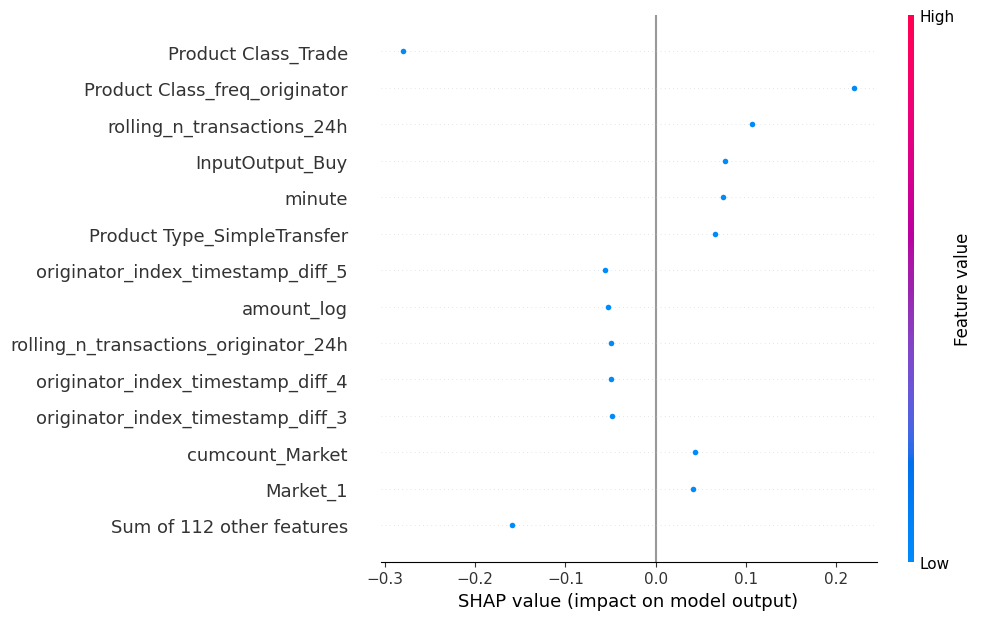

<Figure size 640x480 with 0 Axes>

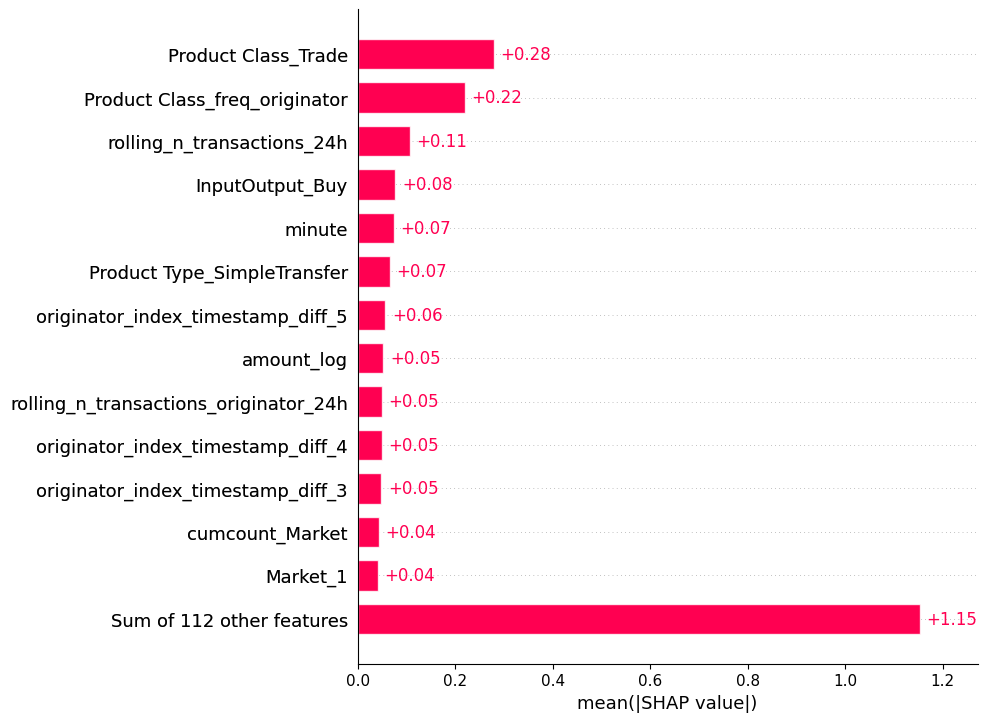

Saved SHAP plots for class 0 to output/shap_plots/
SHAP explanations generated and saved.


In [38]:
get_shap_explanations_mlp_class(model, X_train_shap, X_test[idx].reshape(1, -1), feature_names, filename='figs/shap_plots/shap_amaretto_GM')

## 2.2. Transactions with rounded normalized amounts bought or sold within an account:
It is unusual for transactions in capital markets to have rounded amounts (unless they occur in markets where foreign exchange conversion causes rounding errors).  
Selected indexes from testing set: 2762491, 1154

### 2.2.1. Correct prediction:

In [59]:
df_correct_preds.filter((pl.col("Anomaly") == 2))

shape: (255, 132)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ ind ┆ Mod ┆ id  ┆ dat ┆ Ori ┆ Ano ┆ Ano ┆ amo ┆ Inp ┆ Inp ┆ Mar ┆ Mar ┆ Mar ┆ Mar ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Cur ┆ Cur ┆ day ┆ day ┆ hou ┆ min ┆ is_ ┆ ori ┆ ori ┆ ori ┆ ori ┆ ori ┆ mar ┆ mar ┆ mar ┆ mar ┆ mar ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ ori ┆ mar ┆ pro ┆ pro ┆ day ┆ day ┆ day ┆ day ┆ hou ┆ hou ┆ min ┆ min ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ cum ┆ cum ┆ cum ┆ cum ┆ cum ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur │
│ ex  ┆ el  ┆ --- ┆ eti ┆ gin ┆ mal ┆ mal ┆ unt ┆ utO ┆ utO ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ ren ┆ ren ┆ _of ┆ _of ┆ r   ┆ ute ┆ rou ┆ gin ┆ gin ┆ gin ┆ gin ┆ gin ┆ ket ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ gin ┆ ket ┆ duc ┆ duc ┆ _of ┆ _of ┆ _of ┆ _of ┆ r_s ┆ r_c ┆ ute ┆ ute ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ cou ┆ cou ┆ cou ┆ cou ┆ cou ┆ utO ┆ ket ┆ duc ┆ duc ┆ ren │
│ --- ┆ Pre ┆ u32 ┆ me  ┆ ato ┆ y   ┆ y_b ┆ _lo ┆ utp ┆ utp ┆ _1  ┆ _2  ┆ _3  ┆ _4  ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ cy_ ┆ cy_ ┆ _we ┆ _mo ┆ --- ┆ --- ┆ nde ┆ ato ┆ ato ┆ ato ┆ ato ┆ ato ┆ _in ┆ _in ┆ _in ┆ _in ┆ _in ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ ato ┆ _in ┆ t_t ┆ t_c ┆ _we ┆ _we ┆ _mo ┆ _mo ┆ in  ┆ os  ┆ _si ┆ _co ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ utp ┆ _fr ┆ t   ┆ t   ┆ cy_ │
│ u32 ┆ dic ┆     ┆ --- ┆ r   ┆ --- ┆ in  ┆ g   ┆ ut_ ┆ ut_ ┆ --- ┆ --- ┆ --- ┆ --- ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Cla ┆ Cla ┆ Cla ┆ Cla ┆ 1   ┆ 2   ┆ ek  ┆ nth ┆ i8  ┆ i8  ┆ d   ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ dex ┆ dex ┆ dex ┆ dex ┆ dex ┆ ype ┆ ype ┆ ype ┆ ype ┆ ype ┆ las ┆ las ┆ las ┆ las ┆ las ┆ r_i ┆ dex ┆ ype ┆ las ┆ ek_ ┆ ek_ ┆ nth ┆ nth ┆ --- ┆ --- ┆ n   ┆ s   ┆ ean ┆ ean ┆ ean ┆ ean ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ ean ┆ ean ┆ ean ┆ ean ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur ┆ ut_ ┆ eq_ ┆ Typ ┆ Cla ┆ fre │
│     ┆ tio 

In [15]:
#idx = 2762491
idx = 8891
x = torch.tensor(X_test[idx], dtype=torch.float32)
x[:6]

tensor([-0.1902,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000])

In [16]:
model.encoder.eval()
test_transaction_latent = model.encoder(x)
test_transaction_latent = test_transaction_latent.cpu().detach().numpy()
test_transaction_latent = test_transaction_latent.reshape(1, -1)
test_transaction_latent.shape

(1, 16)

In [17]:
k = 9
distances, indices = knn.kneighbors(test_transaction_latent, n_neighbors=k)
print(indices)
print(distances)

[[ 2042020 21929896 19400304  7201048 21932647  9597328  7279020  7278765
  14283185]]
[[1.21820784 1.21957815 1.38504803 1.43631518 1.46090198 1.52041495
  1.525056   1.56103003 1.61031008]]


In [18]:
df_correct_preds.filter(pl.col("index") == idx)

shape: (1, 132)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ ind ┆ Mod ┆ id  ┆ dat ┆ Ori ┆ Ano ┆ Ano ┆ amo ┆ Inp ┆ Inp ┆ Mar ┆ Mar ┆ Mar ┆ Mar ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Cur ┆ Cur ┆ day ┆ day ┆ hou ┆ min ┆ is_ ┆ ori ┆ ori ┆ ori ┆ ori ┆ ori ┆ mar ┆ mar ┆ mar ┆ mar ┆ mar ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ ori ┆ mar ┆ pro ┆ pro ┆ day ┆ day ┆ day ┆ day ┆ hou ┆ hou ┆ min ┆ min ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ cum ┆ cum ┆ cum ┆ cum ┆ cum ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur │
│ ex  ┆ el  ┆ --- ┆ eti ┆ gin ┆ mal ┆ mal ┆ unt ┆ utO ┆ utO ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ ren ┆ ren ┆ _of ┆ _of ┆ r   ┆ ute ┆ rou ┆ gin ┆ gin ┆ gin ┆ gin ┆ gin ┆ ket ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ gin ┆ ket ┆ duc ┆ duc ┆ _of ┆ _of ┆ _of ┆ _of ┆ r_s ┆ r_c ┆ ute ┆ ute ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ cou ┆ cou ┆ cou ┆ cou ┆ cou ┆ utO ┆ ket ┆ duc ┆ duc ┆ ren │
│ --- ┆ Pre ┆ u32 ┆ me  ┆ ato ┆ y   ┆ y_b ┆ _lo ┆ utp ┆ utp ┆ _1  ┆ _2  ┆ _3  ┆ _4  ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ cy_ ┆ cy_ ┆ _we ┆ _mo ┆ --- ┆ --- ┆ nde ┆ ato ┆ ato ┆ ato ┆ ato ┆ ato ┆ _in ┆ _in ┆ _in ┆ _in ┆ _in ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ ato ┆ _in ┆ t_t ┆ t_c ┆ _we ┆ _we ┆ _mo ┆ _mo ┆ in  ┆ os  ┆ _si ┆ _co ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ utp ┆ _fr ┆ t   ┆ t   ┆ cy_ │
│ u32 ┆ dic ┆     ┆ --- ┆ r   ┆ --- ┆ in  ┆ g   ┆ ut_ ┆ ut_ ┆ --- ┆ --- ┆ --- ┆ --- ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Cla ┆ Cla ┆ Cla ┆ Cla ┆ 1   ┆ 2   ┆ ek  ┆ nth ┆ i8  ┆ i8  ┆ d   ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ dex ┆ dex ┆ dex ┆ dex ┆ dex ┆ ype ┆ ype ┆ ype ┆ ype ┆ ype ┆ las ┆ las ┆ las ┆ las ┆ las ┆ r_i ┆ dex ┆ ype ┆ las ┆ ek_ ┆ ek_ ┆ nth ┆ nth ┆ --- ┆ --- ┆ n   ┆ s   ┆ ean ┆ ean ┆ ean ┆ ean ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ ean ┆ ean ┆ ean ┆ ean ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur ┆ ut_ ┆ eq_ ┆ Typ ┆ Cla ┆ fre │
│     ┆ tio ┆ 

In [19]:
df_train[indices.flatten().tolist()]

shape: (9, 132)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ ind ┆ Mod ┆ id  ┆ dat ┆ Ori ┆ Ano ┆ Ano ┆ amo ┆ Inp ┆ Inp ┆ Mar ┆ Mar ┆ Mar ┆ Mar ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Cur ┆ Cur ┆ day ┆ day ┆ hou ┆ min ┆ is_ ┆ ori ┆ ori ┆ ori ┆ ori ┆ ori ┆ mar ┆ mar ┆ mar ┆ mar ┆ mar ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ ori ┆ mar ┆ pro ┆ pro ┆ day ┆ day ┆ day ┆ day ┆ hou ┆ hou ┆ min ┆ min ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ cum ┆ cum ┆ cum ┆ cum ┆ cum ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur │
│ ex  ┆ el  ┆ --- ┆ eti ┆ gin ┆ mal ┆ mal ┆ unt ┆ utO ┆ utO ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ ren ┆ ren ┆ _of ┆ _of ┆ r   ┆ ute ┆ rou ┆ gin ┆ gin ┆ gin ┆ gin ┆ gin ┆ ket ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ gin ┆ ket ┆ duc ┆ duc ┆ _of ┆ _of ┆ _of ┆ _of ┆ r_s ┆ r_c ┆ ute ┆ ute ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ cou ┆ cou ┆ cou ┆ cou ┆ cou ┆ utO ┆ ket ┆ duc ┆ duc ┆ ren │
│ --- ┆ Pre ┆ u32 ┆ me  ┆ ato ┆ y   ┆ y_b ┆ _lo ┆ utp ┆ utp ┆ _1  ┆ _2  ┆ _3  ┆ _4  ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ cy_ ┆ cy_ ┆ _we ┆ _mo ┆ --- ┆ --- ┆ nde ┆ ato ┆ ato ┆ ato ┆ ato ┆ ato ┆ _in ┆ _in ┆ _in ┆ _in ┆ _in ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ ato ┆ _in ┆ t_t ┆ t_c ┆ _we ┆ _we ┆ _mo ┆ _mo ┆ in  ┆ os  ┆ _si ┆ _co ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ utp ┆ _fr ┆ t   ┆ t   ┆ cy_ │
│ u32 ┆ dic ┆     ┆ --- ┆ r   ┆ --- ┆ in  ┆ g   ┆ ut_ ┆ ut_ ┆ --- ┆ --- ┆ --- ┆ --- ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Cla ┆ Cla ┆ Cla ┆ Cla ┆ 1   ┆ 2   ┆ ek  ┆ nth ┆ i8  ┆ i8  ┆ d   ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ dex ┆ dex ┆ dex ┆ dex ┆ dex ┆ ype ┆ ype ┆ ype ┆ ype ┆ ype ┆ las ┆ las ┆ las ┆ las ┆ las ┆ r_i ┆ dex ┆ ype ┆ las ┆ ek_ ┆ ek_ ┆ nth ┆ nth ┆ --- ┆ --- ┆ n   ┆ s   ┆ ean ┆ ean ┆ ean ┆ ean ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ ean ┆ ean ┆ ean ┆ ean ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur ┆ ut_ ┆ eq_ ┆ Typ ┆ Cla ┆ fre │
│     ┆ tio ┆ 

In [36]:
print(z_train[indices.flatten().tolist()][0])

[-2.2053099   0.24727105  1.1828415  -3.7803001  -0.5508146  -1.5143605
  0.01208356  1.747623   -0.6920035  -1.3358337  -0.90480244 -0.19344726
  0.9980798   1.3941483   0.5763866  -3.5103214 ]


In [37]:
print(z_test[idx])

[-1.966109    0.4253183   1.1670809  -3.9706533  -0.47598058 -1.5607606
 -0.22768898  1.6013286  -0.84036523 -1.244536   -0.68707526 -0.23627256
  0.6007144   1.1737615   0.40720263 -3.2829642 ]


Using 2998 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

SHAP values shape: (1, 125, 6)
2


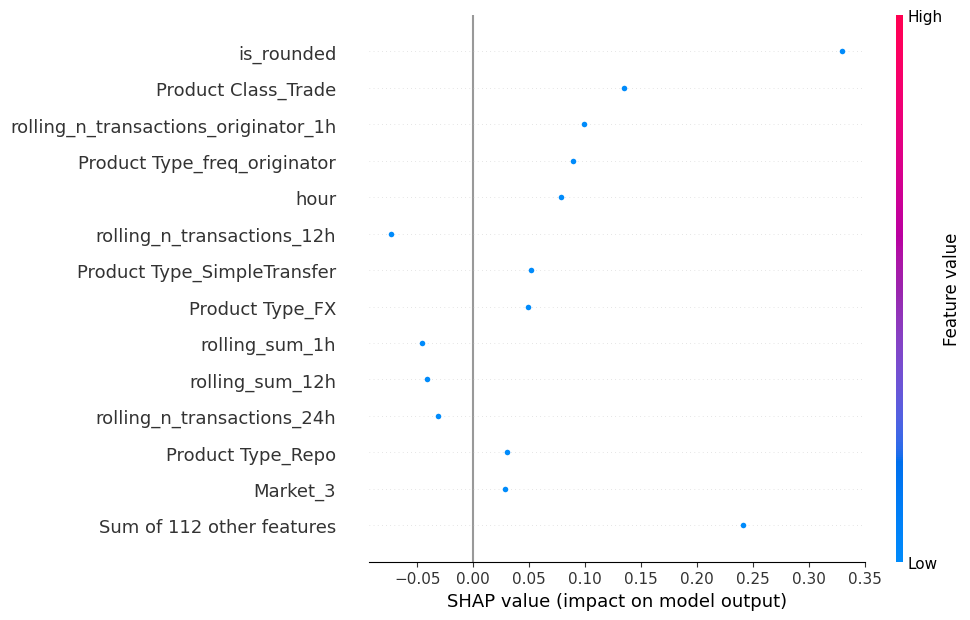

<Figure size 640x480 with 0 Axes>

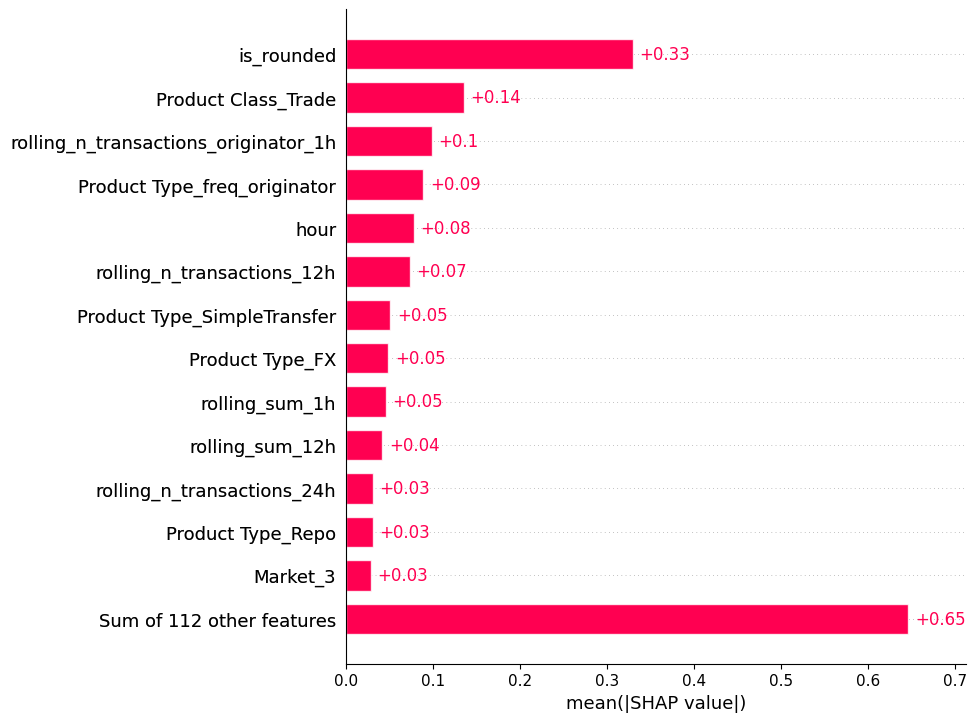

Saved SHAP plots for class 2 to output/shap_plots/
SHAP explanations generated and saved.


In [22]:
get_shap_explanations_mlp_class(model, X_train_shap, X_test[idx].reshape(1, -1), feature_names, filename='figs/shap_plots/shap_amaretto_GM')

### 2.2.2. Inorrect prediction:

In [47]:
idx = 1154
x = torch.tensor(X_test[idx], dtype=torch.float32)
x[:6]

tensor([0.4580, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000])

In [39]:
model.encoder.eval()
test_transaction_latent = model.encoder(x)
test_transaction_latent = test_transaction_latent.cpu().detach().numpy()
test_transaction_latent = test_transaction_latent.reshape(1, -1)
test_transaction_latent.shape

(1, 16)

In [40]:
distances, indices = knn.kneighbors(test_transaction_latent, n_neighbors=k)
print(indices)
print(distances)

[[19319741  4603582  4603425  7115916  4603372  7115920  4603570  4603567
  19320089]]
[[0.42078573 0.55959392 0.56648523 0.63580823 0.69816321 0.74333048
  0.84333616 0.88101697 0.88444638]]


In [41]:
df_wrong_preds.filter(pl.col("index") == idx)

shape: (1, 132)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ ind ┆ Mod ┆ id  ┆ dat ┆ Ori ┆ Ano ┆ Ano ┆ amo ┆ Inp ┆ Inp ┆ Mar ┆ Mar ┆ Mar ┆ Mar ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Cur ┆ Cur ┆ day ┆ day ┆ hou ┆ min ┆ is_ ┆ ori ┆ ori ┆ ori ┆ ori ┆ ori ┆ mar ┆ mar ┆ mar ┆ mar ┆ mar ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ ori ┆ mar ┆ pro ┆ pro ┆ day ┆ day ┆ day ┆ day ┆ hou ┆ hou ┆ min ┆ min ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ cum ┆ cum ┆ cum ┆ cum ┆ cum ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur │
│ ex  ┆ el  ┆ --- ┆ eti ┆ gin ┆ mal ┆ mal ┆ unt ┆ utO ┆ utO ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ ren ┆ ren ┆ _of ┆ _of ┆ r   ┆ ute ┆ rou ┆ gin ┆ gin ┆ gin ┆ gin ┆ gin ┆ ket ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ gin ┆ ket ┆ duc ┆ duc ┆ _of ┆ _of ┆ _of ┆ _of ┆ r_s ┆ r_c ┆ ute ┆ ute ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ cou ┆ cou ┆ cou ┆ cou ┆ cou ┆ utO ┆ ket ┆ duc ┆ duc ┆ ren │
│ --- ┆ Pre ┆ u32 ┆ me  ┆ ato ┆ y   ┆ y_b ┆ _lo ┆ utp ┆ utp ┆ _1  ┆ _2  ┆ _3  ┆ _4  ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ cy_ ┆ cy_ ┆ _we ┆ _mo ┆ --- ┆ --- ┆ nde ┆ ato ┆ ato ┆ ato ┆ ato ┆ ato ┆ _in ┆ _in ┆ _in ┆ _in ┆ _in ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ ato ┆ _in ┆ t_t ┆ t_c ┆ _we ┆ _we ┆ _mo ┆ _mo ┆ in  ┆ os  ┆ _si ┆ _co ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ utp ┆ _fr ┆ t   ┆ t   ┆ cy_ │
│ u32 ┆ dic ┆     ┆ --- ┆ r   ┆ --- ┆ in  ┆ g   ┆ ut_ ┆ ut_ ┆ --- ┆ --- ┆ --- ┆ --- ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Cla ┆ Cla ┆ Cla ┆ Cla ┆ 1   ┆ 2   ┆ ek  ┆ nth ┆ i8  ┆ i8  ┆ d   ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ dex ┆ dex ┆ dex ┆ dex ┆ dex ┆ ype ┆ ype ┆ ype ┆ ype ┆ ype ┆ las ┆ las ┆ las ┆ las ┆ las ┆ r_i ┆ dex ┆ ype ┆ las ┆ ek_ ┆ ek_ ┆ nth ┆ nth ┆ --- ┆ --- ┆ n   ┆ s   ┆ ean ┆ ean ┆ ean ┆ ean ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ ean ┆ ean ┆ ean ┆ ean ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur ┆ ut_ ┆ eq_ ┆ Typ ┆ Cla ┆ fre │
│     ┆ tio ┆ 

In [42]:
df_train[indices.flatten().tolist()]

shape: (9, 132)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ ind ┆ Mod ┆ id  ┆ dat ┆ Ori ┆ Ano ┆ Ano ┆ amo ┆ Inp ┆ Inp ┆ Mar ┆ Mar ┆ Mar ┆ Mar ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Cur ┆ Cur ┆ day ┆ day ┆ hou ┆ min ┆ is_ ┆ ori ┆ ori ┆ ori ┆ ori ┆ ori ┆ mar ┆ mar ┆ mar ┆ mar ┆ mar ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ ori ┆ mar ┆ pro ┆ pro ┆ day ┆ day ┆ day ┆ day ┆ hou ┆ hou ┆ min ┆ min ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ cum ┆ cum ┆ cum ┆ cum ┆ cum ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur │
│ ex  ┆ el  ┆ --- ┆ eti ┆ gin ┆ mal ┆ mal ┆ unt ┆ utO ┆ utO ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ ren ┆ ren ┆ _of ┆ _of ┆ r   ┆ ute ┆ rou ┆ gin ┆ gin ┆ gin ┆ gin ┆ gin ┆ ket ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ gin ┆ ket ┆ duc ┆ duc ┆ _of ┆ _of ┆ _of ┆ _of ┆ r_s ┆ r_c ┆ ute ┆ ute ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ cou ┆ cou ┆ cou ┆ cou ┆ cou ┆ utO ┆ ket ┆ duc ┆ duc ┆ ren │
│ --- ┆ Pre ┆ u32 ┆ me  ┆ ato ┆ y   ┆ y_b ┆ _lo ┆ utp ┆ utp ┆ _1  ┆ _2  ┆ _3  ┆ _4  ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ cy_ ┆ cy_ ┆ _we ┆ _mo ┆ --- ┆ --- ┆ nde ┆ ato ┆ ato ┆ ato ┆ ato ┆ ato ┆ _in ┆ _in ┆ _in ┆ _in ┆ _in ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ ato ┆ _in ┆ t_t ┆ t_c ┆ _we ┆ _we ┆ _mo ┆ _mo ┆ in  ┆ os  ┆ _si ┆ _co ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ utp ┆ _fr ┆ t   ┆ t   ┆ cy_ │
│ u32 ┆ dic ┆     ┆ --- ┆ r   ┆ --- ┆ in  ┆ g   ┆ ut_ ┆ ut_ ┆ --- ┆ --- ┆ --- ┆ --- ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Cla ┆ Cla ┆ Cla ┆ Cla ┆ 1   ┆ 2   ┆ ek  ┆ nth ┆ i8  ┆ i8  ┆ d   ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ dex ┆ dex ┆ dex ┆ dex ┆ dex ┆ ype ┆ ype ┆ ype ┆ ype ┆ ype ┆ las ┆ las ┆ las ┆ las ┆ las ┆ r_i ┆ dex ┆ ype ┆ las ┆ ek_ ┆ ek_ ┆ nth ┆ nth ┆ --- ┆ --- ┆ n   ┆ s   ┆ ean ┆ ean ┆ ean ┆ ean ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ ean ┆ ean ┆ ean ┆ ean ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur ┆ ut_ ┆ eq_ ┆ Typ ┆ Cla ┆ fre │
│     ┆ tio ┆ 

In [43]:
print(z_train[indices.flatten().tolist()][0])

[-2.580623    0.40725732 -0.08335793 -3.7024746   0.39335    -0.5646753
 -0.17899056  1.43648    -2.6491487  -0.87560505 -2.7263784   0.29130527
  1.6478683  -0.9668075  -1.541463   -2.2553492 ]


In [44]:
print(z_test[idx])

[-2.6692252   0.39351767 -0.11413684 -3.536933    0.47446314 -0.46035907
 -0.12506744  1.186397   -2.5895786  -0.8051623  -2.7098064   0.29945144
  1.5998503  -1.0477828  -1.6022947  -2.064708  ]


Using 2998 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

SHAP values shape: (1, 125, 6)
2


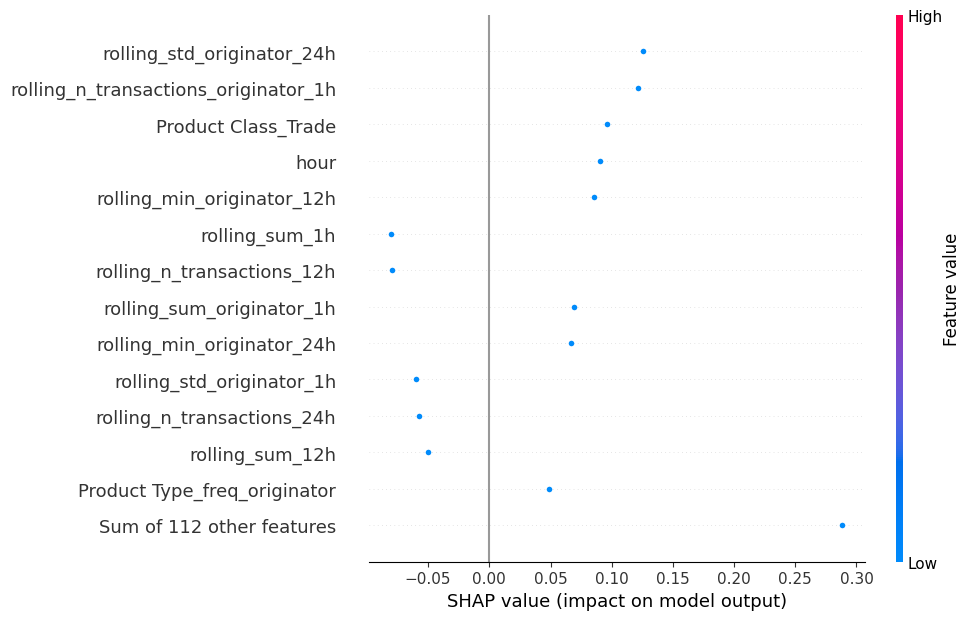

<Figure size 640x480 with 0 Axes>

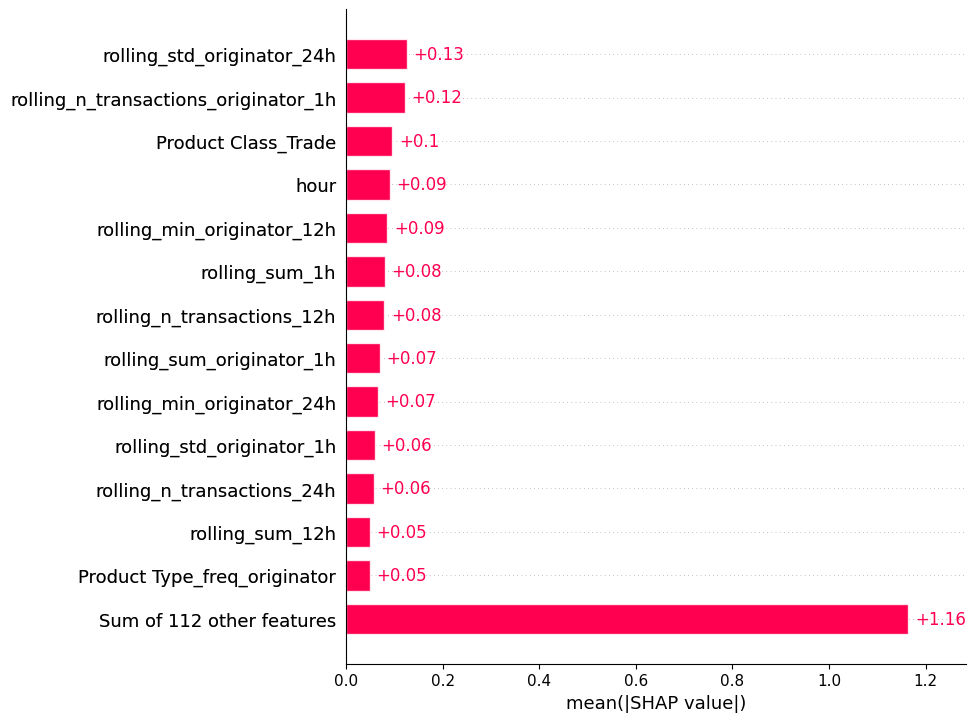

Saved SHAP plots for class 2 to output/shap_plots/
SHAP explanations generated and saved.


In [48]:
get_shap_explanations_mlp_class(model, X_train_shap, X_test[idx].reshape(1, -1), feature_names, filename='figs/shap_plots/shap_amaretto_GM')

## 2.3. Security bought or sold at an unusual time:
It is unusual for clients to trade specific securities outside of a specific timeframe (for example, outside of the opening and closing times of a stock exchange).  
Selected indexes from testing set: 1346, 1781682

### 2.3.1. Correct prediction:

In [45]:
df_correct_preds.filter((pl.col("Anomaly") == 3))

shape: (1_086, 132)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ ind ┆ Mod ┆ id  ┆ dat ┆ Ori ┆ Ano ┆ Ano ┆ amo ┆ Inp ┆ Inp ┆ Mar ┆ Mar ┆ Mar ┆ Mar ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Cur ┆ Cur ┆ day ┆ day ┆ hou ┆ min ┆ is_ ┆ ori ┆ ori ┆ ori ┆ ori ┆ ori ┆ mar ┆ mar ┆ mar ┆ mar ┆ mar ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ ori ┆ mar ┆ pro ┆ pro ┆ day ┆ day ┆ day ┆ day ┆ hou ┆ hou ┆ min ┆ min ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ cum ┆ cum ┆ cum ┆ cum ┆ cum ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur │
│ ex  ┆ el  ┆ --- ┆ eti ┆ gin ┆ mal ┆ mal ┆ unt ┆ utO ┆ utO ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ ren ┆ ren ┆ _of ┆ _of ┆ r   ┆ ute ┆ rou ┆ gin ┆ gin ┆ gin ┆ gin ┆ gin ┆ ket ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ gin ┆ ket ┆ duc ┆ duc ┆ _of ┆ _of ┆ _of ┆ _of ┆ r_s ┆ r_c ┆ ute ┆ ute ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ cou ┆ cou ┆ cou ┆ cou ┆ cou ┆ utO ┆ ket ┆ duc ┆ duc ┆ ren │
│ --- ┆ Pre ┆ u32 ┆ me  ┆ ato ┆ y   ┆ y_b ┆ _lo ┆ utp ┆ utp ┆ _1  ┆ _2  ┆ _3  ┆ _4  ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ cy_ ┆ cy_ ┆ _we ┆ _mo ┆ --- ┆ --- ┆ nde ┆ ato ┆ ato ┆ ato ┆ ato ┆ ato ┆ _in ┆ _in ┆ _in ┆ _in ┆ _in ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ ato ┆ _in ┆ t_t ┆ t_c ┆ _we ┆ _we ┆ _mo ┆ _mo ┆ in  ┆ os  ┆ _si ┆ _co ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ utp ┆ _fr ┆ t   ┆ t   ┆ cy_ │
│ u32 ┆ dic ┆     ┆ --- ┆ r   ┆ --- ┆ in  ┆ g   ┆ ut_ ┆ ut_ ┆ --- ┆ --- ┆ --- ┆ --- ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Cla ┆ Cla ┆ Cla ┆ Cla ┆ 1   ┆ 2   ┆ ek  ┆ nth ┆ i8  ┆ i8  ┆ d   ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ dex ┆ dex ┆ dex ┆ dex ┆ dex ┆ ype ┆ ype ┆ ype ┆ ype ┆ ype ┆ las ┆ las ┆ las ┆ las ┆ las ┆ r_i ┆ dex ┆ ype ┆ las ┆ ek_ ┆ ek_ ┆ nth ┆ nth ┆ --- ┆ --- ┆ n   ┆ s   ┆ ean ┆ ean ┆ ean ┆ ean ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ ean ┆ ean ┆ ean ┆ ean ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur ┆ ut_ ┆ eq_ ┆ Typ ┆ Cla ┆ fre │
│     ┆ ti

In [43]:
idx = 1346
x = torch.tensor(X_test[idx], dtype=torch.float32)
x[:6]

tensor([0.4183, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000])

In [47]:
model.encoder.eval()
test_transaction_latent = model.encoder(x)
test_transaction_latent = test_transaction_latent.cpu().detach().numpy()
test_transaction_latent = test_transaction_latent.reshape(1, -1)
test_transaction_latent.shape

(1, 16)

In [48]:
distances, indices = knn.kneighbors(test_transaction_latent, n_neighbors=k)
print(indices)
print(distances)

[[4603524 4603558 4603502 4603495 4603610 4603675 4603653 4603446 9588528]]
[[0.46142513 0.46398443 0.48677099 0.5048399  0.50544786 0.50720632
  0.5305391  0.53996813 0.54339254]]


In [49]:
df_correct_preds.filter(pl.col("index") == idx)

shape: (1, 132)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ ind ┆ Mod ┆ id  ┆ dat ┆ Ori ┆ Ano ┆ Ano ┆ amo ┆ Inp ┆ Inp ┆ Mar ┆ Mar ┆ Mar ┆ Mar ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Cur ┆ Cur ┆ day ┆ day ┆ hou ┆ min ┆ is_ ┆ ori ┆ ori ┆ ori ┆ ori ┆ ori ┆ mar ┆ mar ┆ mar ┆ mar ┆ mar ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ ori ┆ mar ┆ pro ┆ pro ┆ day ┆ day ┆ day ┆ day ┆ hou ┆ hou ┆ min ┆ min ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ cum ┆ cum ┆ cum ┆ cum ┆ cum ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur │
│ ex  ┆ el  ┆ --- ┆ eti ┆ gin ┆ mal ┆ mal ┆ unt ┆ utO ┆ utO ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ ren ┆ ren ┆ _of ┆ _of ┆ r   ┆ ute ┆ rou ┆ gin ┆ gin ┆ gin ┆ gin ┆ gin ┆ ket ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ gin ┆ ket ┆ duc ┆ duc ┆ _of ┆ _of ┆ _of ┆ _of ┆ r_s ┆ r_c ┆ ute ┆ ute ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ cou ┆ cou ┆ cou ┆ cou ┆ cou ┆ utO ┆ ket ┆ duc ┆ duc ┆ ren │
│ --- ┆ Pre ┆ u32 ┆ me  ┆ ato ┆ y   ┆ y_b ┆ _lo ┆ utp ┆ utp ┆ _1  ┆ _2  ┆ _3  ┆ _4  ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ cy_ ┆ cy_ ┆ _we ┆ _mo ┆ --- ┆ --- ┆ nde ┆ ato ┆ ato ┆ ato ┆ ato ┆ ato ┆ _in ┆ _in ┆ _in ┆ _in ┆ _in ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ ato ┆ _in ┆ t_t ┆ t_c ┆ _we ┆ _we ┆ _mo ┆ _mo ┆ in  ┆ os  ┆ _si ┆ _co ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ utp ┆ _fr ┆ t   ┆ t   ┆ cy_ │
│ u32 ┆ dic ┆     ┆ --- ┆ r   ┆ --- ┆ in  ┆ g   ┆ ut_ ┆ ut_ ┆ --- ┆ --- ┆ --- ┆ --- ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Cla ┆ Cla ┆ Cla ┆ Cla ┆ 1   ┆ 2   ┆ ek  ┆ nth ┆ i8  ┆ i8  ┆ d   ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ dex ┆ dex ┆ dex ┆ dex ┆ dex ┆ ype ┆ ype ┆ ype ┆ ype ┆ ype ┆ las ┆ las ┆ las ┆ las ┆ las ┆ r_i ┆ dex ┆ ype ┆ las ┆ ek_ ┆ ek_ ┆ nth ┆ nth ┆ --- ┆ --- ┆ n   ┆ s   ┆ ean ┆ ean ┆ ean ┆ ean ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ ean ┆ ean ┆ ean ┆ ean ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur ┆ ut_ ┆ eq_ ┆ Typ ┆ Cla ┆ fre │
│     ┆ tio ┆ 

In [50]:
df_train[indices.flatten().tolist()]

shape: (9, 132)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ ind ┆ Mod ┆ id  ┆ dat ┆ Ori ┆ Ano ┆ Ano ┆ amo ┆ Inp ┆ Inp ┆ Mar ┆ Mar ┆ Mar ┆ Mar ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Cur ┆ Cur ┆ day ┆ day ┆ hou ┆ min ┆ is_ ┆ ori ┆ ori ┆ ori ┆ ori ┆ ori ┆ mar ┆ mar ┆ mar ┆ mar ┆ mar ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ ori ┆ mar ┆ pro ┆ pro ┆ day ┆ day ┆ day ┆ day ┆ hou ┆ hou ┆ min ┆ min ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ cum ┆ cum ┆ cum ┆ cum ┆ cum ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur │
│ ex  ┆ el  ┆ --- ┆ eti ┆ gin ┆ mal ┆ mal ┆ unt ┆ utO ┆ utO ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ ren ┆ ren ┆ _of ┆ _of ┆ r   ┆ ute ┆ rou ┆ gin ┆ gin ┆ gin ┆ gin ┆ gin ┆ ket ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ gin ┆ ket ┆ duc ┆ duc ┆ _of ┆ _of ┆ _of ┆ _of ┆ r_s ┆ r_c ┆ ute ┆ ute ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ cou ┆ cou ┆ cou ┆ cou ┆ cou ┆ utO ┆ ket ┆ duc ┆ duc ┆ ren │
│ --- ┆ Pre ┆ u32 ┆ me  ┆ ato ┆ y   ┆ y_b ┆ _lo ┆ utp ┆ utp ┆ _1  ┆ _2  ┆ _3  ┆ _4  ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ cy_ ┆ cy_ ┆ _we ┆ _mo ┆ --- ┆ --- ┆ nde ┆ ato ┆ ato ┆ ato ┆ ato ┆ ato ┆ _in ┆ _in ┆ _in ┆ _in ┆ _in ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ ato ┆ _in ┆ t_t ┆ t_c ┆ _we ┆ _we ┆ _mo ┆ _mo ┆ in  ┆ os  ┆ _si ┆ _co ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ utp ┆ _fr ┆ t   ┆ t   ┆ cy_ │
│ u32 ┆ dic ┆     ┆ --- ┆ r   ┆ --- ┆ in  ┆ g   ┆ ut_ ┆ ut_ ┆ --- ┆ --- ┆ --- ┆ --- ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Cla ┆ Cla ┆ Cla ┆ Cla ┆ 1   ┆ 2   ┆ ek  ┆ nth ┆ i8  ┆ i8  ┆ d   ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ dex ┆ dex ┆ dex ┆ dex ┆ dex ┆ ype ┆ ype ┆ ype ┆ ype ┆ ype ┆ las ┆ las ┆ las ┆ las ┆ las ┆ r_i ┆ dex ┆ ype ┆ las ┆ ek_ ┆ ek_ ┆ nth ┆ nth ┆ --- ┆ --- ┆ n   ┆ s   ┆ ean ┆ ean ┆ ean ┆ ean ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ ean ┆ ean ┆ ean ┆ ean ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur ┆ ut_ ┆ eq_ ┆ Typ ┆ Cla ┆ fre │
│     ┆ tio ┆ 

In [53]:
print(z_train[indices.flatten().tolist()][:2])

[[-2.943015    0.49808413 -0.44908285 -3.8868234   0.09194685 -0.69445544
  -0.33399194  1.3613456  -2.6805503  -0.7521832  -2.4990182   0.14477342
   1.4030517  -0.54363847 -1.9090625  -1.6402696 ]
 [-2.9167001   0.49047643 -0.50252855 -3.907482    0.19890735 -0.50764227
  -0.42853248  1.4338256  -2.6403399  -0.725737   -2.3732367   0.10414317
   1.394406   -0.4753898  -1.7909226  -1.5564725 ]]


In [52]:
print(z_test[idx])

[-3.1553469   0.6383329  -0.4086944  -3.9656613   0.2972519  -0.7436959
 -0.51217353  1.3206539  -2.5542321  -0.7695734  -2.3378134   0.03436419
  1.4448581  -0.5661607  -1.8366312  -1.6601394 ]


Using 2998 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

SHAP values shape: (1, 125, 6)


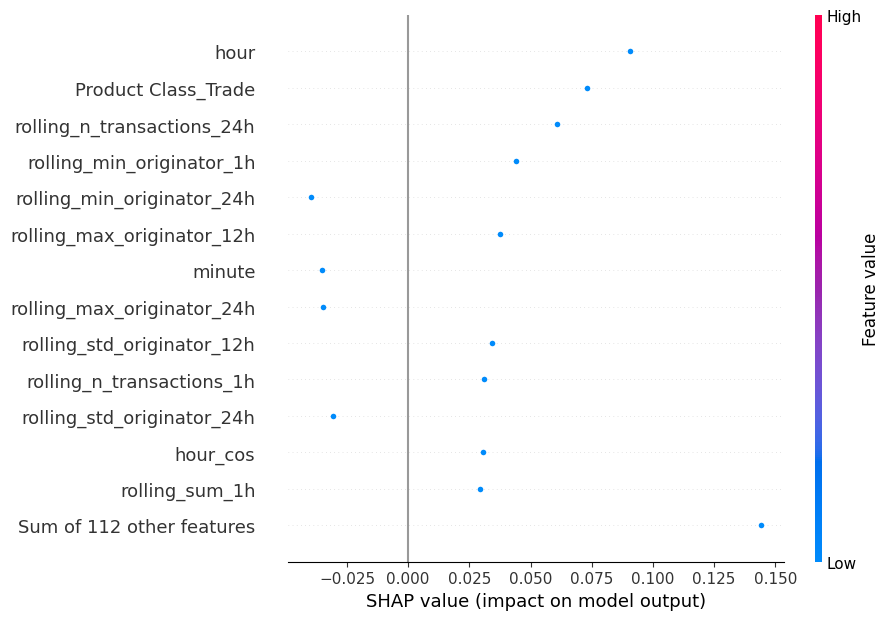

<Figure size 640x480 with 0 Axes>

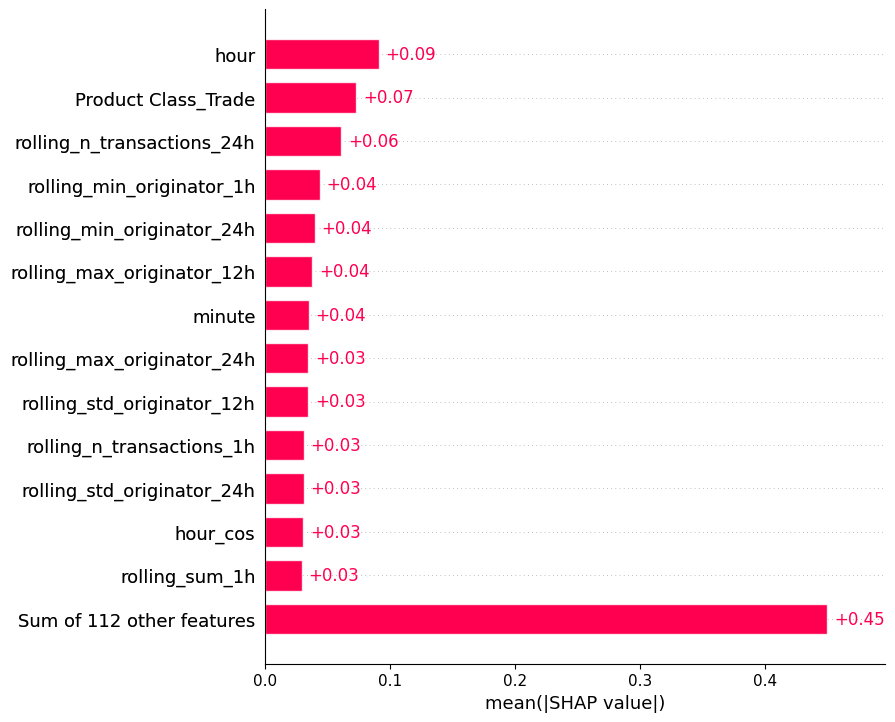

Saved SHAP plots for class 3 to output/shap_plots/
SHAP explanations generated and saved.


In [40]:
get_shap_explanations_mlp_class(model, X_train_shap, X_test[idx].reshape(1, -1), feature_names, filename='figs/shap_plots/shap_amaretto_GM')

### 2.3.2. Incorrect prediction:

In [54]:
df_wrong_preds.filter((pl.col("Model Prediction") == 3))

shape: (45, 132)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ ind ┆ Mod ┆ id  ┆ dat ┆ Ori ┆ Ano ┆ Ano ┆ amo ┆ Inp ┆ Inp ┆ Mar ┆ Mar ┆ Mar ┆ Mar ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Cur ┆ Cur ┆ day ┆ day ┆ hou ┆ min ┆ is_ ┆ ori ┆ ori ┆ ori ┆ ori ┆ ori ┆ mar ┆ mar ┆ mar ┆ mar ┆ mar ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ ori ┆ mar ┆ pro ┆ pro ┆ day ┆ day ┆ day ┆ day ┆ hou ┆ hou ┆ min ┆ min ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ cum ┆ cum ┆ cum ┆ cum ┆ cum ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur │
│ ex  ┆ el  ┆ --- ┆ eti ┆ gin ┆ mal ┆ mal ┆ unt ┆ utO ┆ utO ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ ren ┆ ren ┆ _of ┆ _of ┆ r   ┆ ute ┆ rou ┆ gin ┆ gin ┆ gin ┆ gin ┆ gin ┆ ket ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ gin ┆ ket ┆ duc ┆ duc ┆ _of ┆ _of ┆ _of ┆ _of ┆ r_s ┆ r_c ┆ ute ┆ ute ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ cou ┆ cou ┆ cou ┆ cou ┆ cou ┆ utO ┆ ket ┆ duc ┆ duc ┆ ren │
│ --- ┆ Pre ┆ u32 ┆ me  ┆ ato ┆ y   ┆ y_b ┆ _lo ┆ utp ┆ utp ┆ _1  ┆ _2  ┆ _3  ┆ _4  ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ cy_ ┆ cy_ ┆ _we ┆ _mo ┆ --- ┆ --- ┆ nde ┆ ato ┆ ato ┆ ato ┆ ato ┆ ato ┆ _in ┆ _in ┆ _in ┆ _in ┆ _in ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ ato ┆ _in ┆ t_t ┆ t_c ┆ _we ┆ _we ┆ _mo ┆ _mo ┆ in  ┆ os  ┆ _si ┆ _co ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ utp ┆ _fr ┆ t   ┆ t   ┆ cy_ │
│ u32 ┆ dic ┆     ┆ --- ┆ r   ┆ --- ┆ in  ┆ g   ┆ ut_ ┆ ut_ ┆ --- ┆ --- ┆ --- ┆ --- ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Cla ┆ Cla ┆ Cla ┆ Cla ┆ 1   ┆ 2   ┆ ek  ┆ nth ┆ i8  ┆ i8  ┆ d   ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ dex ┆ dex ┆ dex ┆ dex ┆ dex ┆ ype ┆ ype ┆ ype ┆ ype ┆ ype ┆ las ┆ las ┆ las ┆ las ┆ las ┆ r_i ┆ dex ┆ ype ┆ las ┆ ek_ ┆ ek_ ┆ nth ┆ nth ┆ --- ┆ --- ┆ n   ┆ s   ┆ ean ┆ ean ┆ ean ┆ ean ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ ean ┆ ean ┆ ean ┆ ean ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur ┆ ut_ ┆ eq_ ┆ Typ ┆ Cla ┆ fre │
│     ┆ tio ┆

In [41]:
idx = 1781682
x = torch.tensor(X_test[idx], dtype=torch.float32)
x[:6]

tensor([-1.6971,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000])

In [56]:
model.encoder.eval()
test_transaction_latent = model.encoder(x)
test_transaction_latent = test_transaction_latent.cpu().detach().numpy()
test_transaction_latent = test_transaction_latent.reshape(1, -1)
test_transaction_latent.shape

(1, 16)

In [57]:
distances, indices = knn.kneighbors(test_transaction_latent, n_neighbors=k)
print(indices)
print(distances)

[[15677286 18171622 16848173 15845253 22827709 18172765 17306167  6746998
  20311927]]
[[1.36728764 1.44455564 1.46582866 1.46735299 1.54738748 1.58399832
  1.58922672 1.65531695 1.67415595]]


In [58]:
df_wrong_preds.filter(pl.col("index") == idx)

shape: (1, 132)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ ind ┆ Mod ┆ id  ┆ dat ┆ Ori ┆ Ano ┆ Ano ┆ amo ┆ Inp ┆ Inp ┆ Mar ┆ Mar ┆ Mar ┆ Mar ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Cur ┆ Cur ┆ day ┆ day ┆ hou ┆ min ┆ is_ ┆ ori ┆ ori ┆ ori ┆ ori ┆ ori ┆ mar ┆ mar ┆ mar ┆ mar ┆ mar ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ ori ┆ mar ┆ pro ┆ pro ┆ day ┆ day ┆ day ┆ day ┆ hou ┆ hou ┆ min ┆ min ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ cum ┆ cum ┆ cum ┆ cum ┆ cum ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur │
│ ex  ┆ el  ┆ --- ┆ eti ┆ gin ┆ mal ┆ mal ┆ unt ┆ utO ┆ utO ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ ren ┆ ren ┆ _of ┆ _of ┆ r   ┆ ute ┆ rou ┆ gin ┆ gin ┆ gin ┆ gin ┆ gin ┆ ket ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ gin ┆ ket ┆ duc ┆ duc ┆ _of ┆ _of ┆ _of ┆ _of ┆ r_s ┆ r_c ┆ ute ┆ ute ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ cou ┆ cou ┆ cou ┆ cou ┆ cou ┆ utO ┆ ket ┆ duc ┆ duc ┆ ren │
│ --- ┆ Pre ┆ u32 ┆ me  ┆ ato ┆ y   ┆ y_b ┆ _lo ┆ utp ┆ utp ┆ _1  ┆ _2  ┆ _3  ┆ _4  ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ cy_ ┆ cy_ ┆ _we ┆ _mo ┆ --- ┆ --- ┆ nde ┆ ato ┆ ato ┆ ato ┆ ato ┆ ato ┆ _in ┆ _in ┆ _in ┆ _in ┆ _in ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ ato ┆ _in ┆ t_t ┆ t_c ┆ _we ┆ _we ┆ _mo ┆ _mo ┆ in  ┆ os  ┆ _si ┆ _co ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ utp ┆ _fr ┆ t   ┆ t   ┆ cy_ │
│ u32 ┆ dic ┆     ┆ --- ┆ r   ┆ --- ┆ in  ┆ g   ┆ ut_ ┆ ut_ ┆ --- ┆ --- ┆ --- ┆ --- ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Cla ┆ Cla ┆ Cla ┆ Cla ┆ 1   ┆ 2   ┆ ek  ┆ nth ┆ i8  ┆ i8  ┆ d   ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ dex ┆ dex ┆ dex ┆ dex ┆ dex ┆ ype ┆ ype ┆ ype ┆ ype ┆ ype ┆ las ┆ las ┆ las ┆ las ┆ las ┆ r_i ┆ dex ┆ ype ┆ las ┆ ek_ ┆ ek_ ┆ nth ┆ nth ┆ --- ┆ --- ┆ n   ┆ s   ┆ ean ┆ ean ┆ ean ┆ ean ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ ean ┆ ean ┆ ean ┆ ean ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur ┆ ut_ ┆ eq_ ┆ Typ ┆ Cla ┆ fre │
│     ┆ tio ┆ 

In [59]:
df_train[indices.flatten().tolist()]

shape: (9, 132)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ ind ┆ Mod ┆ id  ┆ dat ┆ Ori ┆ Ano ┆ Ano ┆ amo ┆ Inp ┆ Inp ┆ Mar ┆ Mar ┆ Mar ┆ Mar ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Cur ┆ Cur ┆ day ┆ day ┆ hou ┆ min ┆ is_ ┆ ori ┆ ori ┆ ori ┆ ori ┆ ori ┆ mar ┆ mar ┆ mar ┆ mar ┆ mar ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ ori ┆ mar ┆ pro ┆ pro ┆ day ┆ day ┆ day ┆ day ┆ hou ┆ hou ┆ min ┆ min ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ cum ┆ cum ┆ cum ┆ cum ┆ cum ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur │
│ ex  ┆ el  ┆ --- ┆ eti ┆ gin ┆ mal ┆ mal ┆ unt ┆ utO ┆ utO ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ ren ┆ ren ┆ _of ┆ _of ┆ r   ┆ ute ┆ rou ┆ gin ┆ gin ┆ gin ┆ gin ┆ gin ┆ ket ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ gin ┆ ket ┆ duc ┆ duc ┆ _of ┆ _of ┆ _of ┆ _of ┆ r_s ┆ r_c ┆ ute ┆ ute ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ cou ┆ cou ┆ cou ┆ cou ┆ cou ┆ utO ┆ ket ┆ duc ┆ duc ┆ ren │
│ --- ┆ Pre ┆ u32 ┆ me  ┆ ato ┆ y   ┆ y_b ┆ _lo ┆ utp ┆ utp ┆ _1  ┆ _2  ┆ _3  ┆ _4  ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ cy_ ┆ cy_ ┆ _we ┆ _mo ┆ --- ┆ --- ┆ nde ┆ ato ┆ ato ┆ ato ┆ ato ┆ ato ┆ _in ┆ _in ┆ _in ┆ _in ┆ _in ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ ato ┆ _in ┆ t_t ┆ t_c ┆ _we ┆ _we ┆ _mo ┆ _mo ┆ in  ┆ os  ┆ _si ┆ _co ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ utp ┆ _fr ┆ t   ┆ t   ┆ cy_ │
│ u32 ┆ dic ┆     ┆ --- ┆ r   ┆ --- ┆ in  ┆ g   ┆ ut_ ┆ ut_ ┆ --- ┆ --- ┆ --- ┆ --- ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Cla ┆ Cla ┆ Cla ┆ Cla ┆ 1   ┆ 2   ┆ ek  ┆ nth ┆ i8  ┆ i8  ┆ d   ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ dex ┆ dex ┆ dex ┆ dex ┆ dex ┆ ype ┆ ype ┆ ype ┆ ype ┆ ype ┆ las ┆ las ┆ las ┆ las ┆ las ┆ r_i ┆ dex ┆ ype ┆ las ┆ ek_ ┆ ek_ ┆ nth ┆ nth ┆ --- ┆ --- ┆ n   ┆ s   ┆ ean ┆ ean ┆ ean ┆ ean ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ ean ┆ ean ┆ ean ┆ ean ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur ┆ ut_ ┆ eq_ ┆ Typ ┆ Cla ┆ fre │
│     ┆ tio ┆ 

In [60]:
print(z_train[indices.flatten().tolist()][:2])

[[-2.0570624   0.17379062 -0.8519243  -3.6490903  -0.49881846 -0.87352675
  -0.5234573   0.3419947  -2.4500933  -1.1359335  -1.8786758   1.4867889
  -0.42023656  1.1299585  -1.3835087  -2.1449351 ]
 [-2.051531    0.06298916 -0.8561177  -3.639601   -0.7383856  -1.0891514
   0.06118202  0.4935416  -2.7967646  -1.1235758  -2.0418215   1.4637522
  -0.43159977  1.6191574  -1.4891049  -2.096597  ]]


In [61]:
print(z_test[idx])

[-1.9576206   0.48322308 -0.4118706  -3.5923517  -0.25153545 -1.6087607
 -0.08688624  0.2753136  -2.8073256  -1.1732817  -2.0877256   1.5980335
 -0.3997041   1.0095682  -0.9852133  -2.786474  ]


Using 2998 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

SHAP values shape: (1, 125, 6)


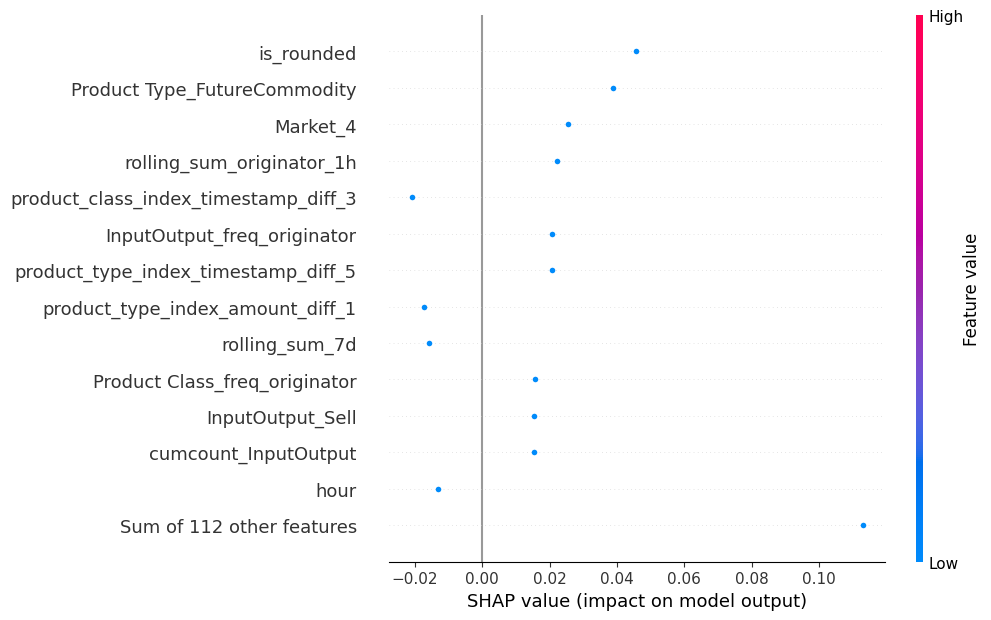

<Figure size 640x480 with 0 Axes>

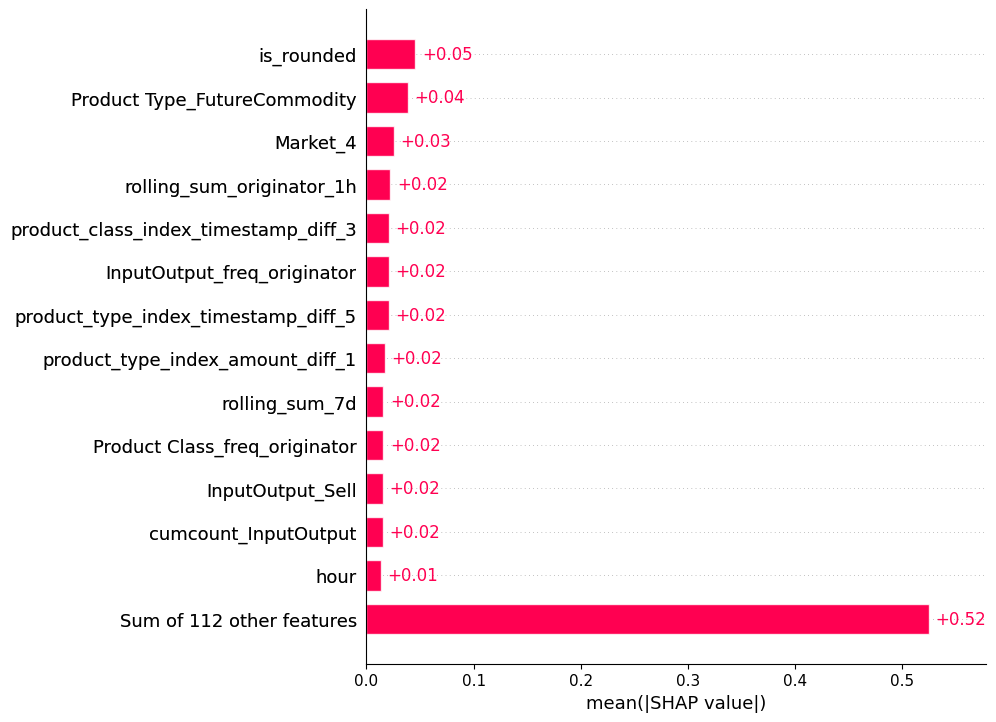

Saved SHAP plots for class 3 to output/shap_plots/
SHAP explanations generated and saved.


In [42]:
get_shap_explanations_mlp_class(model, X_train_shap, X_test[idx].reshape(1, -1), feature_names, filename='figs/shap_plots/shap_amaretto_GM')

## 2.4. Large asset withdrawal:
A sudden spike in transaction amount withdrawn from an account or transferred out, which deviates from the previous transactional activity and is absent of any commercial rationale or related corporate action event.  
Selected indexes from testing set: 4495, 2761298

### 2.4.1. Correct prediction:

In [62]:
df_correct_preds.filter((pl.col("Anomaly") == 4))

shape: (1_939, 132)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ ind ┆ Mod ┆ id  ┆ dat ┆ Ori ┆ Ano ┆ Ano ┆ amo ┆ Inp ┆ Inp ┆ Mar ┆ Mar ┆ Mar ┆ Mar ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Cur ┆ Cur ┆ day ┆ day ┆ hou ┆ min ┆ is_ ┆ ori ┆ ori ┆ ori ┆ ori ┆ ori ┆ mar ┆ mar ┆ mar ┆ mar ┆ mar ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ ori ┆ mar ┆ pro ┆ pro ┆ day ┆ day ┆ day ┆ day ┆ hou ┆ hou ┆ min ┆ min ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ cum ┆ cum ┆ cum ┆ cum ┆ cum ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur │
│ ex  ┆ el  ┆ --- ┆ eti ┆ gin ┆ mal ┆ mal ┆ unt ┆ utO ┆ utO ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ ren ┆ ren ┆ _of ┆ _of ┆ r   ┆ ute ┆ rou ┆ gin ┆ gin ┆ gin ┆ gin ┆ gin ┆ ket ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ gin ┆ ket ┆ duc ┆ duc ┆ _of ┆ _of ┆ _of ┆ _of ┆ r_s ┆ r_c ┆ ute ┆ ute ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ cou ┆ cou ┆ cou ┆ cou ┆ cou ┆ utO ┆ ket ┆ duc ┆ duc ┆ ren │
│ --- ┆ Pre ┆ u32 ┆ me  ┆ ato ┆ y   ┆ y_b ┆ _lo ┆ utp ┆ utp ┆ _1  ┆ _2  ┆ _3  ┆ _4  ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ cy_ ┆ cy_ ┆ _we ┆ _mo ┆ --- ┆ --- ┆ nde ┆ ato ┆ ato ┆ ato ┆ ato ┆ ato ┆ _in ┆ _in ┆ _in ┆ _in ┆ _in ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ ato ┆ _in ┆ t_t ┆ t_c ┆ _we ┆ _we ┆ _mo ┆ _mo ┆ in  ┆ os  ┆ _si ┆ _co ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ utp ┆ _fr ┆ t   ┆ t   ┆ cy_ │
│ u32 ┆ dic ┆     ┆ --- ┆ r   ┆ --- ┆ in  ┆ g   ┆ ut_ ┆ ut_ ┆ --- ┆ --- ┆ --- ┆ --- ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Cla ┆ Cla ┆ Cla ┆ Cla ┆ 1   ┆ 2   ┆ ek  ┆ nth ┆ i8  ┆ i8  ┆ d   ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ dex ┆ dex ┆ dex ┆ dex ┆ dex ┆ ype ┆ ype ┆ ype ┆ ype ┆ ype ┆ las ┆ las ┆ las ┆ las ┆ las ┆ r_i ┆ dex ┆ ype ┆ las ┆ ek_ ┆ ek_ ┆ nth ┆ nth ┆ --- ┆ --- ┆ n   ┆ s   ┆ ean ┆ ean ┆ ean ┆ ean ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ ean ┆ ean ┆ ean ┆ ean ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur ┆ ut_ ┆ eq_ ┆ Typ ┆ Cla ┆ fre │
│     ┆ ti

In [23]:
idx = 4495
x = torch.tensor(X_test[idx], dtype=torch.float32)
x[:6]

tensor([1.3561, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000])

In [64]:
model.encoder.eval()
test_transaction_latent = model.encoder(x)
test_transaction_latent = test_transaction_latent.cpu().detach().numpy()
test_transaction_latent = test_transaction_latent.reshape(1, -1)
test_transaction_latent.shape

(1, 16)

In [65]:
distances, indices = knn.kneighbors(test_transaction_latent, n_neighbors=k)
print(indices)
print(distances)

[[16917465 16920035 16918342 14233026 14238390 16917984  7124105 21889929
  14239911]]
[[0.80218154 0.88134098 0.89245576 0.9518522  0.96299958 1.02013934
  1.04897094 1.05241311 1.05501747]]


In [66]:
df_correct_preds.filter(pl.col("index") == idx)

shape: (1, 132)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ ind ┆ Mod ┆ id  ┆ dat ┆ Ori ┆ Ano ┆ Ano ┆ amo ┆ Inp ┆ Inp ┆ Mar ┆ Mar ┆ Mar ┆ Mar ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Cur ┆ Cur ┆ day ┆ day ┆ hou ┆ min ┆ is_ ┆ ori ┆ ori ┆ ori ┆ ori ┆ ori ┆ mar ┆ mar ┆ mar ┆ mar ┆ mar ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ ori ┆ mar ┆ pro ┆ pro ┆ day ┆ day ┆ day ┆ day ┆ hou ┆ hou ┆ min ┆ min ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ cum ┆ cum ┆ cum ┆ cum ┆ cum ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur │
│ ex  ┆ el  ┆ --- ┆ eti ┆ gin ┆ mal ┆ mal ┆ unt ┆ utO ┆ utO ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ ren ┆ ren ┆ _of ┆ _of ┆ r   ┆ ute ┆ rou ┆ gin ┆ gin ┆ gin ┆ gin ┆ gin ┆ ket ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ gin ┆ ket ┆ duc ┆ duc ┆ _of ┆ _of ┆ _of ┆ _of ┆ r_s ┆ r_c ┆ ute ┆ ute ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ cou ┆ cou ┆ cou ┆ cou ┆ cou ┆ utO ┆ ket ┆ duc ┆ duc ┆ ren │
│ --- ┆ Pre ┆ u32 ┆ me  ┆ ato ┆ y   ┆ y_b ┆ _lo ┆ utp ┆ utp ┆ _1  ┆ _2  ┆ _3  ┆ _4  ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ cy_ ┆ cy_ ┆ _we ┆ _mo ┆ --- ┆ --- ┆ nde ┆ ato ┆ ato ┆ ato ┆ ato ┆ ato ┆ _in ┆ _in ┆ _in ┆ _in ┆ _in ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ ato ┆ _in ┆ t_t ┆ t_c ┆ _we ┆ _we ┆ _mo ┆ _mo ┆ in  ┆ os  ┆ _si ┆ _co ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ utp ┆ _fr ┆ t   ┆ t   ┆ cy_ │
│ u32 ┆ dic ┆     ┆ --- ┆ r   ┆ --- ┆ in  ┆ g   ┆ ut_ ┆ ut_ ┆ --- ┆ --- ┆ --- ┆ --- ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Cla ┆ Cla ┆ Cla ┆ Cla ┆ 1   ┆ 2   ┆ ek  ┆ nth ┆ i8  ┆ i8  ┆ d   ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ dex ┆ dex ┆ dex ┆ dex ┆ dex ┆ ype ┆ ype ┆ ype ┆ ype ┆ ype ┆ las ┆ las ┆ las ┆ las ┆ las ┆ r_i ┆ dex ┆ ype ┆ las ┆ ek_ ┆ ek_ ┆ nth ┆ nth ┆ --- ┆ --- ┆ n   ┆ s   ┆ ean ┆ ean ┆ ean ┆ ean ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ ean ┆ ean ┆ ean ┆ ean ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur ┆ ut_ ┆ eq_ ┆ Typ ┆ Cla ┆ fre │
│     ┆ tio ┆ 

In [67]:
df_train[indices.flatten().tolist()]

shape: (9, 132)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ ind ┆ Mod ┆ id  ┆ dat ┆ Ori ┆ Ano ┆ Ano ┆ amo ┆ Inp ┆ Inp ┆ Mar ┆ Mar ┆ Mar ┆ Mar ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Cur ┆ Cur ┆ day ┆ day ┆ hou ┆ min ┆ is_ ┆ ori ┆ ori ┆ ori ┆ ori ┆ ori ┆ mar ┆ mar ┆ mar ┆ mar ┆ mar ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ ori ┆ mar ┆ pro ┆ pro ┆ day ┆ day ┆ day ┆ day ┆ hou ┆ hou ┆ min ┆ min ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ cum ┆ cum ┆ cum ┆ cum ┆ cum ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur │
│ ex  ┆ el  ┆ --- ┆ eti ┆ gin ┆ mal ┆ mal ┆ unt ┆ utO ┆ utO ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ ren ┆ ren ┆ _of ┆ _of ┆ r   ┆ ute ┆ rou ┆ gin ┆ gin ┆ gin ┆ gin ┆ gin ┆ ket ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ gin ┆ ket ┆ duc ┆ duc ┆ _of ┆ _of ┆ _of ┆ _of ┆ r_s ┆ r_c ┆ ute ┆ ute ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ cou ┆ cou ┆ cou ┆ cou ┆ cou ┆ utO ┆ ket ┆ duc ┆ duc ┆ ren │
│ --- ┆ Pre ┆ u32 ┆ me  ┆ ato ┆ y   ┆ y_b ┆ _lo ┆ utp ┆ utp ┆ _1  ┆ _2  ┆ _3  ┆ _4  ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ cy_ ┆ cy_ ┆ _we ┆ _mo ┆ --- ┆ --- ┆ nde ┆ ato ┆ ato ┆ ato ┆ ato ┆ ato ┆ _in ┆ _in ┆ _in ┆ _in ┆ _in ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ ato ┆ _in ┆ t_t ┆ t_c ┆ _we ┆ _we ┆ _mo ┆ _mo ┆ in  ┆ os  ┆ _si ┆ _co ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ utp ┆ _fr ┆ t   ┆ t   ┆ cy_ │
│ u32 ┆ dic ┆     ┆ --- ┆ r   ┆ --- ┆ in  ┆ g   ┆ ut_ ┆ ut_ ┆ --- ┆ --- ┆ --- ┆ --- ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Cla ┆ Cla ┆ Cla ┆ Cla ┆ 1   ┆ 2   ┆ ek  ┆ nth ┆ i8  ┆ i8  ┆ d   ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ dex ┆ dex ┆ dex ┆ dex ┆ dex ┆ ype ┆ ype ┆ ype ┆ ype ┆ ype ┆ las ┆ las ┆ las ┆ las ┆ las ┆ r_i ┆ dex ┆ ype ┆ las ┆ ek_ ┆ ek_ ┆ nth ┆ nth ┆ --- ┆ --- ┆ n   ┆ s   ┆ ean ┆ ean ┆ ean ┆ ean ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ ean ┆ ean ┆ ean ┆ ean ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur ┆ ut_ ┆ eq_ ┆ Typ ┆ Cla ┆ fre │
│     ┆ tio ┆ 

In [68]:
print(z_train[indices.flatten().tolist()][2:4])

[[-2.5287163   0.08925657 -1.0436959  -2.2916865   0.01805495  0.16156557
   0.12177697  0.02986081 -3.2514107   0.21756345 -1.7563679   1.2222317
  -0.18035884 -0.14375179 -2.9769034  -0.30376405]
 [-3.1217947   0.4865284  -1.1972506  -2.4588223   0.3951564  -0.55916935
   0.11703131 -0.30033958 -3.7261515  -0.10053436 -1.8222938   1.3768468
  -0.25881064  0.13256116 -2.8868325  -0.15595038]]


In [69]:
print(z_test[idx])

[-2.8849626   0.02349877 -1.0501988  -2.4290168  -0.09516186 -0.2293686
  0.26867017 -0.07365832 -3.6037285   0.06307574 -1.6560655   1.4680604
 -0.34788698  0.24830647 -3.1803067  -0.22151987]


Using 2998 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

SHAP values shape: (1, 125, 6)
4


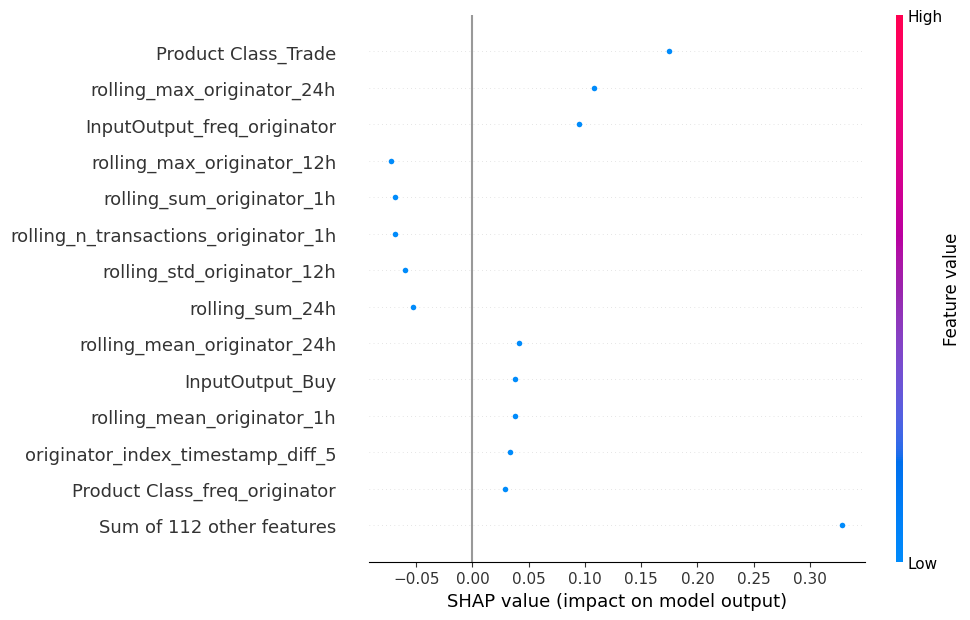

<Figure size 640x480 with 0 Axes>

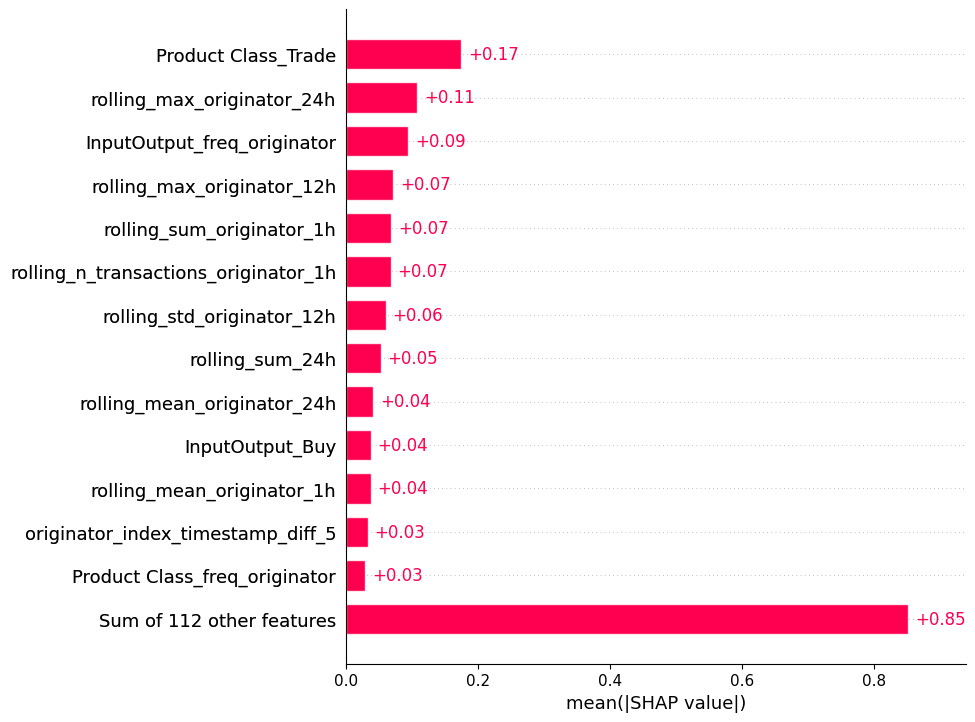

Saved SHAP plots for class 4 to output/shap_plots/
SHAP explanations generated and saved.


In [24]:
get_shap_explanations_mlp_class(model, X_train_shap, X_test[idx].reshape(1, -1), feature_names, filename='figs/shap_plots/shap_amaretto_GM')

### 2.4.2. Incorrect prediction:

In [74]:
df_wrong_preds.filter((pl.col("Model Prediction") == 4) & (pl.col("Anomaly") == 5))

shape: (1_023, 132)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ ind ┆ Mod ┆ id  ┆ dat ┆ Ori ┆ Ano ┆ Ano ┆ amo ┆ Inp ┆ Inp ┆ Mar ┆ Mar ┆ Mar ┆ Mar ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Cur ┆ Cur ┆ day ┆ day ┆ hou ┆ min ┆ is_ ┆ ori ┆ ori ┆ ori ┆ ori ┆ ori ┆ mar ┆ mar ┆ mar ┆ mar ┆ mar ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ ori ┆ mar ┆ pro ┆ pro ┆ day ┆ day ┆ day ┆ day ┆ hou ┆ hou ┆ min ┆ min ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ cum ┆ cum ┆ cum ┆ cum ┆ cum ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur │
│ ex  ┆ el  ┆ --- ┆ eti ┆ gin ┆ mal ┆ mal ┆ unt ┆ utO ┆ utO ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ ren ┆ ren ┆ _of ┆ _of ┆ r   ┆ ute ┆ rou ┆ gin ┆ gin ┆ gin ┆ gin ┆ gin ┆ ket ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ gin ┆ ket ┆ duc ┆ duc ┆ _of ┆ _of ┆ _of ┆ _of ┆ r_s ┆ r_c ┆ ute ┆ ute ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ cou ┆ cou ┆ cou ┆ cou ┆ cou ┆ utO ┆ ket ┆ duc ┆ duc ┆ ren │
│ --- ┆ Pre ┆ u32 ┆ me  ┆ ato ┆ y   ┆ y_b ┆ _lo ┆ utp ┆ utp ┆ _1  ┆ _2  ┆ _3  ┆ _4  ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ cy_ ┆ cy_ ┆ _we ┆ _mo ┆ --- ┆ --- ┆ nde ┆ ato ┆ ato ┆ ato ┆ ato ┆ ato ┆ _in ┆ _in ┆ _in ┆ _in ┆ _in ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ ato ┆ _in ┆ t_t ┆ t_c ┆ _we ┆ _we ┆ _mo ┆ _mo ┆ in  ┆ os  ┆ _si ┆ _co ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ utp ┆ _fr ┆ t   ┆ t   ┆ cy_ │
│ u32 ┆ dic ┆     ┆ --- ┆ r   ┆ --- ┆ in  ┆ g   ┆ ut_ ┆ ut_ ┆ --- ┆ --- ┆ --- ┆ --- ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Cla ┆ Cla ┆ Cla ┆ Cla ┆ 1   ┆ 2   ┆ ek  ┆ nth ┆ i8  ┆ i8  ┆ d   ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ dex ┆ dex ┆ dex ┆ dex ┆ dex ┆ ype ┆ ype ┆ ype ┆ ype ┆ ype ┆ las ┆ las ┆ las ┆ las ┆ las ┆ r_i ┆ dex ┆ ype ┆ las ┆ ek_ ┆ ek_ ┆ nth ┆ nth ┆ --- ┆ --- ┆ n   ┆ s   ┆ ean ┆ ean ┆ ean ┆ ean ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ ean ┆ ean ┆ ean ┆ ean ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur ┆ ut_ ┆ eq_ ┆ Typ ┆ Cla ┆ fre │
│     ┆ ti

In [25]:
idx = 2761298
x = torch.tensor(X_test[idx], dtype=torch.float32)
x[:6]

tensor([0.3377, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000])

In [87]:
model.encoder.eval()
test_transaction_latent = model.encoder(x)
test_transaction_latent = test_transaction_latent.cpu().detach().numpy()
test_transaction_latent = test_transaction_latent.reshape(1, -1)
test_transaction_latent.shape

(1, 16)

In [88]:
distances, indices = knn.kneighbors(test_transaction_latent, n_neighbors=k)
print(indices)
print(distances)

[[17294684 15579676 15576175 15576935 15577749  1503830  1504681 15575782
   7525276]]
[[0.51974666 0.58682841 0.6071142  0.62124211 0.62175608 0.64193046
  0.64288425 0.64615911 0.69354057]]


In [89]:
df_wrong_preds.filter(pl.col("index") == idx)

shape: (1, 132)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ ind ┆ Mod ┆ id  ┆ dat ┆ Ori ┆ Ano ┆ Ano ┆ amo ┆ Inp ┆ Inp ┆ Mar ┆ Mar ┆ Mar ┆ Mar ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Cur ┆ Cur ┆ day ┆ day ┆ hou ┆ min ┆ is_ ┆ ori ┆ ori ┆ ori ┆ ori ┆ ori ┆ mar ┆ mar ┆ mar ┆ mar ┆ mar ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ ori ┆ mar ┆ pro ┆ pro ┆ day ┆ day ┆ day ┆ day ┆ hou ┆ hou ┆ min ┆ min ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ cum ┆ cum ┆ cum ┆ cum ┆ cum ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur │
│ ex  ┆ el  ┆ --- ┆ eti ┆ gin ┆ mal ┆ mal ┆ unt ┆ utO ┆ utO ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ ren ┆ ren ┆ _of ┆ _of ┆ r   ┆ ute ┆ rou ┆ gin ┆ gin ┆ gin ┆ gin ┆ gin ┆ ket ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ gin ┆ ket ┆ duc ┆ duc ┆ _of ┆ _of ┆ _of ┆ _of ┆ r_s ┆ r_c ┆ ute ┆ ute ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ cou ┆ cou ┆ cou ┆ cou ┆ cou ┆ utO ┆ ket ┆ duc ┆ duc ┆ ren │
│ --- ┆ Pre ┆ u32 ┆ me  ┆ ato ┆ y   ┆ y_b ┆ _lo ┆ utp ┆ utp ┆ _1  ┆ _2  ┆ _3  ┆ _4  ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ cy_ ┆ cy_ ┆ _we ┆ _mo ┆ --- ┆ --- ┆ nde ┆ ato ┆ ato ┆ ato ┆ ato ┆ ato ┆ _in ┆ _in ┆ _in ┆ _in ┆ _in ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ ato ┆ _in ┆ t_t ┆ t_c ┆ _we ┆ _we ┆ _mo ┆ _mo ┆ in  ┆ os  ┆ _si ┆ _co ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ utp ┆ _fr ┆ t   ┆ t   ┆ cy_ │
│ u32 ┆ dic ┆     ┆ --- ┆ r   ┆ --- ┆ in  ┆ g   ┆ ut_ ┆ ut_ ┆ --- ┆ --- ┆ --- ┆ --- ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Cla ┆ Cla ┆ Cla ┆ Cla ┆ 1   ┆ 2   ┆ ek  ┆ nth ┆ i8  ┆ i8  ┆ d   ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ dex ┆ dex ┆ dex ┆ dex ┆ dex ┆ ype ┆ ype ┆ ype ┆ ype ┆ ype ┆ las ┆ las ┆ las ┆ las ┆ las ┆ r_i ┆ dex ┆ ype ┆ las ┆ ek_ ┆ ek_ ┆ nth ┆ nth ┆ --- ┆ --- ┆ n   ┆ s   ┆ ean ┆ ean ┆ ean ┆ ean ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ ean ┆ ean ┆ ean ┆ ean ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur ┆ ut_ ┆ eq_ ┆ Typ ┆ Cla ┆ fre │
│     ┆ tio ┆ 

In [91]:
df_train[indices.flatten().tolist()]

shape: (9, 132)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ ind ┆ Mod ┆ id  ┆ dat ┆ Ori ┆ Ano ┆ Ano ┆ amo ┆ Inp ┆ Inp ┆ Mar ┆ Mar ┆ Mar ┆ Mar ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Cur ┆ Cur ┆ day ┆ day ┆ hou ┆ min ┆ is_ ┆ ori ┆ ori ┆ ori ┆ ori ┆ ori ┆ mar ┆ mar ┆ mar ┆ mar ┆ mar ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ ori ┆ mar ┆ pro ┆ pro ┆ day ┆ day ┆ day ┆ day ┆ hou ┆ hou ┆ min ┆ min ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ cum ┆ cum ┆ cum ┆ cum ┆ cum ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur │
│ ex  ┆ el  ┆ --- ┆ eti ┆ gin ┆ mal ┆ mal ┆ unt ┆ utO ┆ utO ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ ren ┆ ren ┆ _of ┆ _of ┆ r   ┆ ute ┆ rou ┆ gin ┆ gin ┆ gin ┆ gin ┆ gin ┆ ket ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ gin ┆ ket ┆ duc ┆ duc ┆ _of ┆ _of ┆ _of ┆ _of ┆ r_s ┆ r_c ┆ ute ┆ ute ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ cou ┆ cou ┆ cou ┆ cou ┆ cou ┆ utO ┆ ket ┆ duc ┆ duc ┆ ren │
│ --- ┆ Pre ┆ u32 ┆ me  ┆ ato ┆ y   ┆ y_b ┆ _lo ┆ utp ┆ utp ┆ _1  ┆ _2  ┆ _3  ┆ _4  ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ cy_ ┆ cy_ ┆ _we ┆ _mo ┆ --- ┆ --- ┆ nde ┆ ato ┆ ato ┆ ato ┆ ato ┆ ato ┆ _in ┆ _in ┆ _in ┆ _in ┆ _in ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ ato ┆ _in ┆ t_t ┆ t_c ┆ _we ┆ _we ┆ _mo ┆ _mo ┆ in  ┆ os  ┆ _si ┆ _co ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ utp ┆ _fr ┆ t   ┆ t   ┆ cy_ │
│ u32 ┆ dic ┆     ┆ --- ┆ r   ┆ --- ┆ in  ┆ g   ┆ ut_ ┆ ut_ ┆ --- ┆ --- ┆ --- ┆ --- ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Cla ┆ Cla ┆ Cla ┆ Cla ┆ 1   ┆ 2   ┆ ek  ┆ nth ┆ i8  ┆ i8  ┆ d   ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ dex ┆ dex ┆ dex ┆ dex ┆ dex ┆ ype ┆ ype ┆ ype ┆ ype ┆ ype ┆ las ┆ las ┆ las ┆ las ┆ las ┆ r_i ┆ dex ┆ ype ┆ las ┆ ek_ ┆ ek_ ┆ nth ┆ nth ┆ --- ┆ --- ┆ n   ┆ s   ┆ ean ┆ ean ┆ ean ┆ ean ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ ean ┆ ean ┆ ean ┆ ean ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur ┆ ut_ ┆ eq_ ┆ Typ ┆ Cla ┆ fre │
│     ┆ tio ┆ 

In [92]:
print(z_train[indices.flatten().tolist()][:2])

[[-2.4331093   0.9509997  -0.87176096 -3.1386654  -1.0228022  -0.88607335
  -0.27441552 -0.5133108  -3.018287   -0.18518315 -0.15477887  0.3923129
  -1.2918235   2.049067   -1.7767009  -0.7480476 ]
 [-2.4637065   0.84158844 -0.9778522  -2.8729079  -0.81690234 -0.7319219
  -0.25929818 -0.4418549  -3.2682087   0.06021937  0.24896924  0.52185583
  -1.7033967   1.9127183  -1.7117262  -0.578028  ]]


In [93]:
print(z_test[idx])

[-2.450901    0.9282147  -0.891068   -3.0944896  -0.90527314 -0.7225768
 -0.4362544  -0.4227226  -3.0839684  -0.02157213  0.04562509  0.56950283
 -1.4937688   2.0946276  -1.5747468  -0.82387644]


Using 2998 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

SHAP values shape: (1, 125, 6)
4


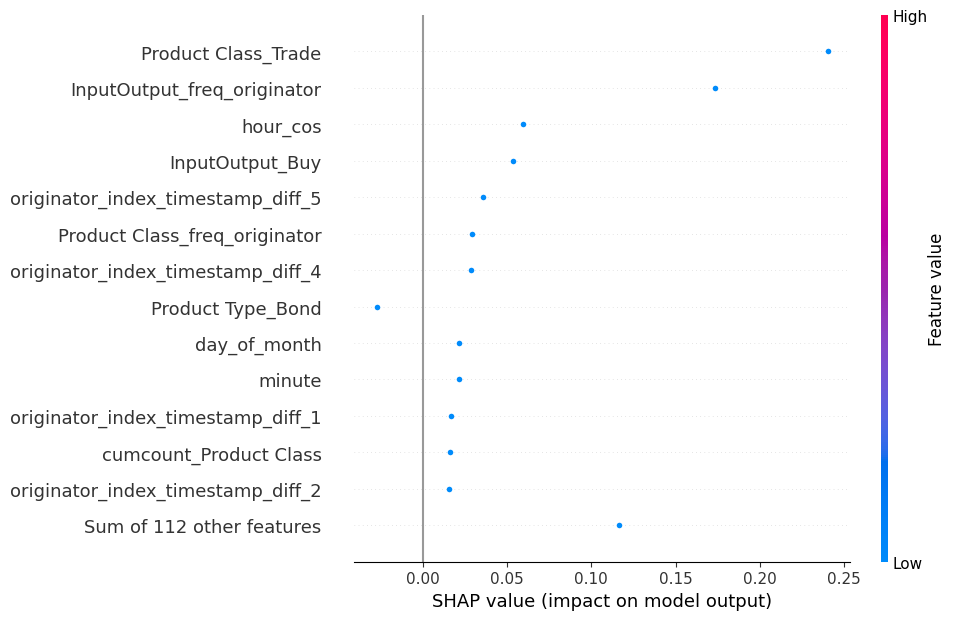

<Figure size 640x480 with 0 Axes>

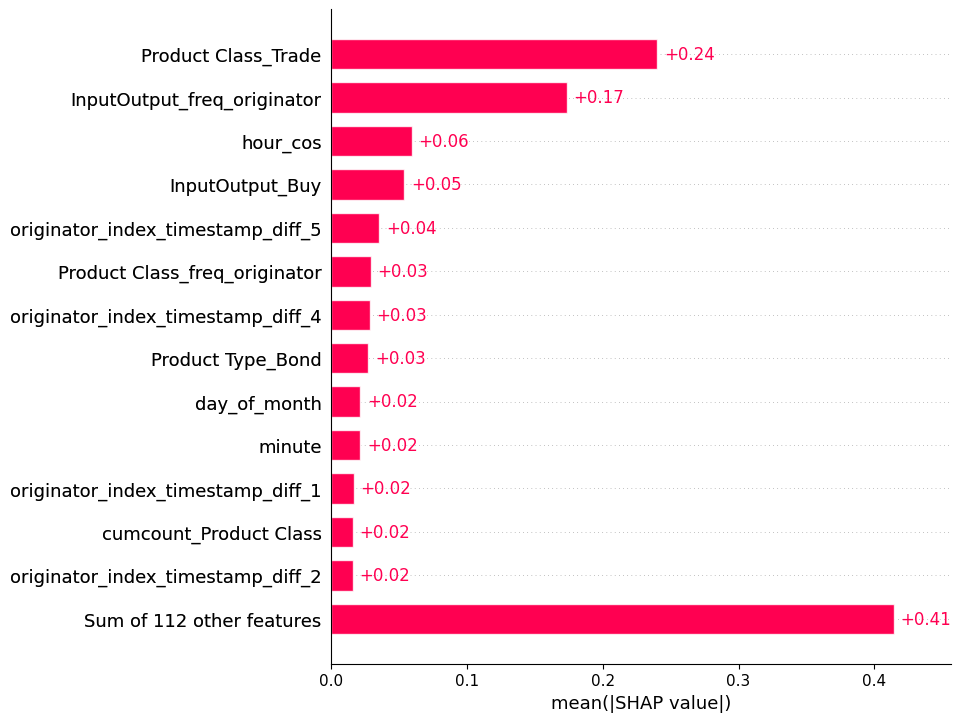

Saved SHAP plots for class 4 to output/shap_plots/
SHAP explanations generated and saved.


In [26]:
get_shap_explanations_mlp_class(model, X_train_shap, X_test[idx].reshape(1, -1), feature_names, filename='figs/shap_plots/shap_amaretto_GM')

## 2.5. An unusually large amount of collateral transferred in and out of an account within a short period of time:
This behavior is unusual as a client would not be able to invest by simply trading collateral, or at least such a strategy would be unusual.  
Selected indexes from testing set: 2762376, 516444

### 2.5.1. Correct prediction:

In [27]:
df_correct_preds.filter((pl.col("Anomaly") == 5))

shape: (953, 132)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ ind ┆ Mod ┆ id  ┆ dat ┆ Ori ┆ Ano ┆ Ano ┆ amo ┆ Inp ┆ Inp ┆ Mar ┆ Mar ┆ Mar ┆ Mar ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Cur ┆ Cur ┆ day ┆ day ┆ hou ┆ min ┆ is_ ┆ ori ┆ ori ┆ ori ┆ ori ┆ ori ┆ mar ┆ mar ┆ mar ┆ mar ┆ mar ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ ori ┆ mar ┆ pro ┆ pro ┆ day ┆ day ┆ day ┆ day ┆ hou ┆ hou ┆ min ┆ min ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ cum ┆ cum ┆ cum ┆ cum ┆ cum ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur │
│ ex  ┆ el  ┆ --- ┆ eti ┆ gin ┆ mal ┆ mal ┆ unt ┆ utO ┆ utO ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ ren ┆ ren ┆ _of ┆ _of ┆ r   ┆ ute ┆ rou ┆ gin ┆ gin ┆ gin ┆ gin ┆ gin ┆ ket ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ gin ┆ ket ┆ duc ┆ duc ┆ _of ┆ _of ┆ _of ┆ _of ┆ r_s ┆ r_c ┆ ute ┆ ute ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ cou ┆ cou ┆ cou ┆ cou ┆ cou ┆ utO ┆ ket ┆ duc ┆ duc ┆ ren │
│ --- ┆ Pre ┆ u32 ┆ me  ┆ ato ┆ y   ┆ y_b ┆ _lo ┆ utp ┆ utp ┆ _1  ┆ _2  ┆ _3  ┆ _4  ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ cy_ ┆ cy_ ┆ _we ┆ _mo ┆ --- ┆ --- ┆ nde ┆ ato ┆ ato ┆ ato ┆ ato ┆ ato ┆ _in ┆ _in ┆ _in ┆ _in ┆ _in ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ ato ┆ _in ┆ t_t ┆ t_c ┆ _we ┆ _we ┆ _mo ┆ _mo ┆ in  ┆ os  ┆ _si ┆ _co ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ utp ┆ _fr ┆ t   ┆ t   ┆ cy_ │
│ u32 ┆ dic ┆     ┆ --- ┆ r   ┆ --- ┆ in  ┆ g   ┆ ut_ ┆ ut_ ┆ --- ┆ --- ┆ --- ┆ --- ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Cla ┆ Cla ┆ Cla ┆ Cla ┆ 1   ┆ 2   ┆ ek  ┆ nth ┆ i8  ┆ i8  ┆ d   ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ dex ┆ dex ┆ dex ┆ dex ┆ dex ┆ ype ┆ ype ┆ ype ┆ ype ┆ ype ┆ las ┆ las ┆ las ┆ las ┆ las ┆ r_i ┆ dex ┆ ype ┆ las ┆ ek_ ┆ ek_ ┆ nth ┆ nth ┆ --- ┆ --- ┆ n   ┆ s   ┆ ean ┆ ean ┆ ean ┆ ean ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ ean ┆ ean ┆ ean ┆ ean ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur ┆ ut_ ┆ eq_ ┆ Typ ┆ Cla ┆ fre │
│     ┆ tio 

In [28]:
idx = 2762376
x = torch.tensor(X_test[idx], dtype=torch.float32)
x[:6]

tensor([0.3138, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000])

In [101]:
model.encoder.eval()
test_transaction_latent = model.encoder(x)
test_transaction_latent = test_transaction_latent.cpu().detach().numpy()
test_transaction_latent = test_transaction_latent.reshape(1, -1)
test_transaction_latent.shape

(1, 16)

In [102]:
distances, indices = knn.kneighbors(test_transaction_latent, n_neighbors=k)
print(indices)
print(distances)

[[19623124  7598978 14740996 19287387 20164346  5526145 19624980 19288534
  19739580]]
[[0.52873516 0.55274493 0.56253332 0.56486255 0.57306278 0.58062702
  0.5827989  0.58416122 0.58481294]]


In [103]:
df_correct_preds.filter(pl.col("index") == idx)

shape: (1, 132)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ ind ┆ Mod ┆ id  ┆ dat ┆ Ori ┆ Ano ┆ Ano ┆ amo ┆ Inp ┆ Inp ┆ Mar ┆ Mar ┆ Mar ┆ Mar ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Cur ┆ Cur ┆ day ┆ day ┆ hou ┆ min ┆ is_ ┆ ori ┆ ori ┆ ori ┆ ori ┆ ori ┆ mar ┆ mar ┆ mar ┆ mar ┆ mar ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ ori ┆ mar ┆ pro ┆ pro ┆ day ┆ day ┆ day ┆ day ┆ hou ┆ hou ┆ min ┆ min ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ cum ┆ cum ┆ cum ┆ cum ┆ cum ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur │
│ ex  ┆ el  ┆ --- ┆ eti ┆ gin ┆ mal ┆ mal ┆ unt ┆ utO ┆ utO ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ ren ┆ ren ┆ _of ┆ _of ┆ r   ┆ ute ┆ rou ┆ gin ┆ gin ┆ gin ┆ gin ┆ gin ┆ ket ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ gin ┆ ket ┆ duc ┆ duc ┆ _of ┆ _of ┆ _of ┆ _of ┆ r_s ┆ r_c ┆ ute ┆ ute ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ cou ┆ cou ┆ cou ┆ cou ┆ cou ┆ utO ┆ ket ┆ duc ┆ duc ┆ ren │
│ --- ┆ Pre ┆ u32 ┆ me  ┆ ato ┆ y   ┆ y_b ┆ _lo ┆ utp ┆ utp ┆ _1  ┆ _2  ┆ _3  ┆ _4  ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ cy_ ┆ cy_ ┆ _we ┆ _mo ┆ --- ┆ --- ┆ nde ┆ ato ┆ ato ┆ ato ┆ ato ┆ ato ┆ _in ┆ _in ┆ _in ┆ _in ┆ _in ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ ato ┆ _in ┆ t_t ┆ t_c ┆ _we ┆ _we ┆ _mo ┆ _mo ┆ in  ┆ os  ┆ _si ┆ _co ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ utp ┆ _fr ┆ t   ┆ t   ┆ cy_ │
│ u32 ┆ dic ┆     ┆ --- ┆ r   ┆ --- ┆ in  ┆ g   ┆ ut_ ┆ ut_ ┆ --- ┆ --- ┆ --- ┆ --- ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Cla ┆ Cla ┆ Cla ┆ Cla ┆ 1   ┆ 2   ┆ ek  ┆ nth ┆ i8  ┆ i8  ┆ d   ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ dex ┆ dex ┆ dex ┆ dex ┆ dex ┆ ype ┆ ype ┆ ype ┆ ype ┆ ype ┆ las ┆ las ┆ las ┆ las ┆ las ┆ r_i ┆ dex ┆ ype ┆ las ┆ ek_ ┆ ek_ ┆ nth ┆ nth ┆ --- ┆ --- ┆ n   ┆ s   ┆ ean ┆ ean ┆ ean ┆ ean ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ ean ┆ ean ┆ ean ┆ ean ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur ┆ ut_ ┆ eq_ ┆ Typ ┆ Cla ┆ fre │
│     ┆ tio ┆ 

In [104]:
df_train[indices.flatten().tolist()]

shape: (9, 132)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ ind ┆ Mod ┆ id  ┆ dat ┆ Ori ┆ Ano ┆ Ano ┆ amo ┆ Inp ┆ Inp ┆ Mar ┆ Mar ┆ Mar ┆ Mar ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Cur ┆ Cur ┆ day ┆ day ┆ hou ┆ min ┆ is_ ┆ ori ┆ ori ┆ ori ┆ ori ┆ ori ┆ mar ┆ mar ┆ mar ┆ mar ┆ mar ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ ori ┆ mar ┆ pro ┆ pro ┆ day ┆ day ┆ day ┆ day ┆ hou ┆ hou ┆ min ┆ min ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ cum ┆ cum ┆ cum ┆ cum ┆ cum ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur │
│ ex  ┆ el  ┆ --- ┆ eti ┆ gin ┆ mal ┆ mal ┆ unt ┆ utO ┆ utO ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ ren ┆ ren ┆ _of ┆ _of ┆ r   ┆ ute ┆ rou ┆ gin ┆ gin ┆ gin ┆ gin ┆ gin ┆ ket ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ gin ┆ ket ┆ duc ┆ duc ┆ _of ┆ _of ┆ _of ┆ _of ┆ r_s ┆ r_c ┆ ute ┆ ute ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ cou ┆ cou ┆ cou ┆ cou ┆ cou ┆ utO ┆ ket ┆ duc ┆ duc ┆ ren │
│ --- ┆ Pre ┆ u32 ┆ me  ┆ ato ┆ y   ┆ y_b ┆ _lo ┆ utp ┆ utp ┆ _1  ┆ _2  ┆ _3  ┆ _4  ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ cy_ ┆ cy_ ┆ _we ┆ _mo ┆ --- ┆ --- ┆ nde ┆ ato ┆ ato ┆ ato ┆ ato ┆ ato ┆ _in ┆ _in ┆ _in ┆ _in ┆ _in ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ ato ┆ _in ┆ t_t ┆ t_c ┆ _we ┆ _we ┆ _mo ┆ _mo ┆ in  ┆ os  ┆ _si ┆ _co ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ utp ┆ _fr ┆ t   ┆ t   ┆ cy_ │
│ u32 ┆ dic ┆     ┆ --- ┆ r   ┆ --- ┆ in  ┆ g   ┆ ut_ ┆ ut_ ┆ --- ┆ --- ┆ --- ┆ --- ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Cla ┆ Cla ┆ Cla ┆ Cla ┆ 1   ┆ 2   ┆ ek  ┆ nth ┆ i8  ┆ i8  ┆ d   ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ dex ┆ dex ┆ dex ┆ dex ┆ dex ┆ ype ┆ ype ┆ ype ┆ ype ┆ ype ┆ las ┆ las ┆ las ┆ las ┆ las ┆ r_i ┆ dex ┆ ype ┆ las ┆ ek_ ┆ ek_ ┆ nth ┆ nth ┆ --- ┆ --- ┆ n   ┆ s   ┆ ean ┆ ean ┆ ean ┆ ean ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ ean ┆ ean ┆ ean ┆ ean ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur ┆ ut_ ┆ eq_ ┆ Typ ┆ Cla ┆ fre │
│     ┆ tio ┆ 

In [105]:
print(z_train[indices.flatten().tolist()][0])

[-1.7206421  -0.84009975 -0.9258529  -1.1255988  -0.8609636   1.2533833
  1.1971354  -1.6296676  -1.4845101  -0.5260371   0.6082765  -0.27374735
 -1.2463502   2.2190332  -1.8727342   2.6298902 ]


In [106]:
print(z_test[idx])

[-1.7510817  -0.6094156  -0.88196003 -1.2582811  -0.91334903  0.9356589
  1.2273142  -1.8647422  -1.5614073  -0.54726833  0.5948409  -0.24358319
 -1.3451564   2.230141   -1.9320678   2.4712605 ]


Using 2998 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

SHAP values shape: (1, 125, 6)
5


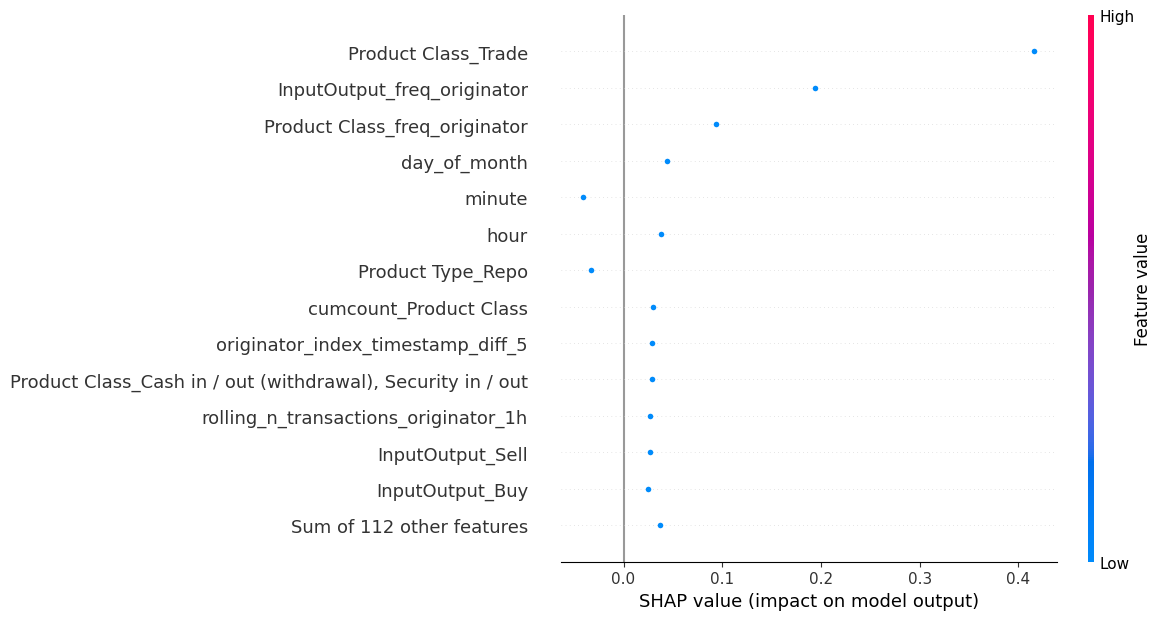

<Figure size 640x480 with 0 Axes>

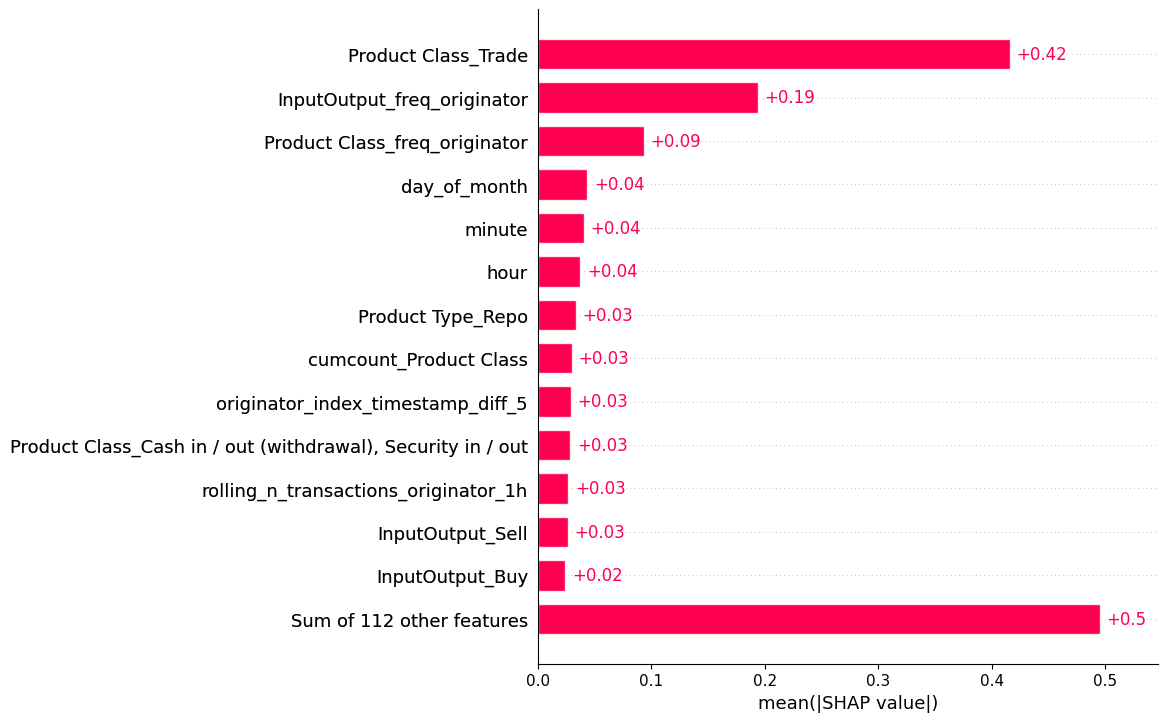

Saved SHAP plots for class 5 to output/shap_plots/
SHAP explanations generated and saved.


In [29]:
get_shap_explanations_mlp_class(model, X_train_shap, X_test[idx].reshape(1, -1), feature_names, filename='figs/shap_plots/shap_amaretto_GM')

### 2.5.2. Incorrect prediction:

In [117]:
df_wrong_preds.filter((pl.col("Model Prediction") == 5))

shape: (16, 132)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ ind ┆ Mod ┆ id  ┆ dat ┆ Ori ┆ Ano ┆ Ano ┆ amo ┆ Inp ┆ Inp ┆ Mar ┆ Mar ┆ Mar ┆ Mar ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Cur ┆ Cur ┆ day ┆ day ┆ hou ┆ min ┆ is_ ┆ ori ┆ ori ┆ ori ┆ ori ┆ ori ┆ mar ┆ mar ┆ mar ┆ mar ┆ mar ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ ori ┆ mar ┆ pro ┆ pro ┆ day ┆ day ┆ day ┆ day ┆ hou ┆ hou ┆ min ┆ min ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ cum ┆ cum ┆ cum ┆ cum ┆ cum ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur │
│ ex  ┆ el  ┆ --- ┆ eti ┆ gin ┆ mal ┆ mal ┆ unt ┆ utO ┆ utO ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ ren ┆ ren ┆ _of ┆ _of ┆ r   ┆ ute ┆ rou ┆ gin ┆ gin ┆ gin ┆ gin ┆ gin ┆ ket ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ gin ┆ ket ┆ duc ┆ duc ┆ _of ┆ _of ┆ _of ┆ _of ┆ r_s ┆ r_c ┆ ute ┆ ute ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ cou ┆ cou ┆ cou ┆ cou ┆ cou ┆ utO ┆ ket ┆ duc ┆ duc ┆ ren │
│ --- ┆ Pre ┆ u32 ┆ me  ┆ ato ┆ y   ┆ y_b ┆ _lo ┆ utp ┆ utp ┆ _1  ┆ _2  ┆ _3  ┆ _4  ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ cy_ ┆ cy_ ┆ _we ┆ _mo ┆ --- ┆ --- ┆ nde ┆ ato ┆ ato ┆ ato ┆ ato ┆ ato ┆ _in ┆ _in ┆ _in ┆ _in ┆ _in ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ ato ┆ _in ┆ t_t ┆ t_c ┆ _we ┆ _we ┆ _mo ┆ _mo ┆ in  ┆ os  ┆ _si ┆ _co ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ utp ┆ _fr ┆ t   ┆ t   ┆ cy_ │
│ u32 ┆ dic ┆     ┆ --- ┆ r   ┆ --- ┆ in  ┆ g   ┆ ut_ ┆ ut_ ┆ --- ┆ --- ┆ --- ┆ --- ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Cla ┆ Cla ┆ Cla ┆ Cla ┆ 1   ┆ 2   ┆ ek  ┆ nth ┆ i8  ┆ i8  ┆ d   ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ dex ┆ dex ┆ dex ┆ dex ┆ dex ┆ ype ┆ ype ┆ ype ┆ ype ┆ ype ┆ las ┆ las ┆ las ┆ las ┆ las ┆ r_i ┆ dex ┆ ype ┆ las ┆ ek_ ┆ ek_ ┆ nth ┆ nth ┆ --- ┆ --- ┆ n   ┆ s   ┆ ean ┆ ean ┆ ean ┆ ean ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ ean ┆ ean ┆ ean ┆ ean ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur ┆ ut_ ┆ eq_ ┆ Typ ┆ Cla ┆ fre │
│     ┆ tio ┆

In [30]:
idx = 516444
x = torch.tensor(X_test[idx], dtype=torch.float32)
x[:6]

tensor([0.6409, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000])

In [140]:
model.encoder.eval()
test_transaction_latent = model.encoder(x)
test_transaction_latent = test_transaction_latent.cpu().detach().numpy()
test_transaction_latent = test_transaction_latent.reshape(1, -1)
test_transaction_latent.shape

(1, 16)

In [141]:
distances, indices = knn.kneighbors(test_transaction_latent, n_neighbors=k)
print(indices)
print(distances)

[[13367421   112867  2231618 19474445 15410589 23586083   115285 13258223
    114612]]
[[0.7462011  0.8666153  0.97474718 0.98308575 0.99158931 1.01107335
  1.03264058 1.05734622 1.0585593 ]]


In [142]:
df_wrong_preds.filter(pl.col("index") == idx)

shape: (1, 132)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ ind ┆ Mod ┆ id  ┆ dat ┆ Ori ┆ Ano ┆ Ano ┆ amo ┆ Inp ┆ Inp ┆ Mar ┆ Mar ┆ Mar ┆ Mar ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Cur ┆ Cur ┆ day ┆ day ┆ hou ┆ min ┆ is_ ┆ ori ┆ ori ┆ ori ┆ ori ┆ ori ┆ mar ┆ mar ┆ mar ┆ mar ┆ mar ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ ori ┆ mar ┆ pro ┆ pro ┆ day ┆ day ┆ day ┆ day ┆ hou ┆ hou ┆ min ┆ min ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ cum ┆ cum ┆ cum ┆ cum ┆ cum ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur │
│ ex  ┆ el  ┆ --- ┆ eti ┆ gin ┆ mal ┆ mal ┆ unt ┆ utO ┆ utO ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ ren ┆ ren ┆ _of ┆ _of ┆ r   ┆ ute ┆ rou ┆ gin ┆ gin ┆ gin ┆ gin ┆ gin ┆ ket ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ gin ┆ ket ┆ duc ┆ duc ┆ _of ┆ _of ┆ _of ┆ _of ┆ r_s ┆ r_c ┆ ute ┆ ute ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ cou ┆ cou ┆ cou ┆ cou ┆ cou ┆ utO ┆ ket ┆ duc ┆ duc ┆ ren │
│ --- ┆ Pre ┆ u32 ┆ me  ┆ ato ┆ y   ┆ y_b ┆ _lo ┆ utp ┆ utp ┆ _1  ┆ _2  ┆ _3  ┆ _4  ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ cy_ ┆ cy_ ┆ _we ┆ _mo ┆ --- ┆ --- ┆ nde ┆ ato ┆ ato ┆ ato ┆ ato ┆ ato ┆ _in ┆ _in ┆ _in ┆ _in ┆ _in ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ ato ┆ _in ┆ t_t ┆ t_c ┆ _we ┆ _we ┆ _mo ┆ _mo ┆ in  ┆ os  ┆ _si ┆ _co ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ utp ┆ _fr ┆ t   ┆ t   ┆ cy_ │
│ u32 ┆ dic ┆     ┆ --- ┆ r   ┆ --- ┆ in  ┆ g   ┆ ut_ ┆ ut_ ┆ --- ┆ --- ┆ --- ┆ --- ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Cla ┆ Cla ┆ Cla ┆ Cla ┆ 1   ┆ 2   ┆ ek  ┆ nth ┆ i8  ┆ i8  ┆ d   ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ dex ┆ dex ┆ dex ┆ dex ┆ dex ┆ ype ┆ ype ┆ ype ┆ ype ┆ ype ┆ las ┆ las ┆ las ┆ las ┆ las ┆ r_i ┆ dex ┆ ype ┆ las ┆ ek_ ┆ ek_ ┆ nth ┆ nth ┆ --- ┆ --- ┆ n   ┆ s   ┆ ean ┆ ean ┆ ean ┆ ean ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ ean ┆ ean ┆ ean ┆ ean ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur ┆ ut_ ┆ eq_ ┆ Typ ┆ Cla ┆ fre │
│     ┆ tio ┆ 

In [143]:
df_train[indices.flatten().tolist()]

shape: (9, 132)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ ind ┆ Mod ┆ id  ┆ dat ┆ Ori ┆ Ano ┆ Ano ┆ amo ┆ Inp ┆ Inp ┆ Mar ┆ Mar ┆ Mar ┆ Mar ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Pro ┆ Cur ┆ Cur ┆ day ┆ day ┆ hou ┆ min ┆ is_ ┆ ori ┆ ori ┆ ori ┆ ori ┆ ori ┆ mar ┆ mar ┆ mar ┆ mar ┆ mar ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ pro ┆ ori ┆ mar ┆ pro ┆ pro ┆ day ┆ day ┆ day ┆ day ┆ hou ┆ hou ┆ min ┆ min ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ rol ┆ cum ┆ cum ┆ cum ┆ cum ┆ cum ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur │
│ ex  ┆ el  ┆ --- ┆ eti ┆ gin ┆ mal ┆ mal ┆ unt ┆ utO ┆ utO ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ ren ┆ ren ┆ _of ┆ _of ┆ r   ┆ ute ┆ rou ┆ gin ┆ gin ┆ gin ┆ gin ┆ gin ┆ ket ┆ ket ┆ ket ┆ ket ┆ ket ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ duc ┆ gin ┆ ket ┆ duc ┆ duc ┆ _of ┆ _of ┆ _of ┆ _of ┆ r_s ┆ r_c ┆ ute ┆ ute ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ lin ┆ cou ┆ cou ┆ cou ┆ cou ┆ cou ┆ utO ┆ ket ┆ duc ┆ duc ┆ ren │
│ --- ┆ Pre ┆ u32 ┆ me  ┆ ato ┆ y   ┆ y_b ┆ _lo ┆ utp ┆ utp ┆ _1  ┆ _2  ┆ _3  ┆ _4  ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ t   ┆ cy_ ┆ cy_ ┆ _we ┆ _mo ┆ --- ┆ --- ┆ nde ┆ ato ┆ ato ┆ ato ┆ ato ┆ ato ┆ _in ┆ _in ┆ _in ┆ _in ┆ _in ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_t ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ t_c ┆ ato ┆ _in ┆ t_t ┆ t_c ┆ _we ┆ _we ┆ _mo ┆ _mo ┆ in  ┆ os  ┆ _si ┆ _co ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_m ┆ g_s ┆ g_s ┆ g_s ┆ g_s ┆ g_n ┆ g_n ┆ g_n ┆ g_n ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ nt_ ┆ utp ┆ _fr ┆ t   ┆ t   ┆ cy_ │
│ u32 ┆ dic ┆     ┆ --- ┆ r   ┆ --- ┆ in  ┆ g   ┆ ut_ ┆ ut_ ┆ --- ┆ --- ┆ --- ┆ --- ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Typ ┆ Cla ┆ Cla ┆ Cla ┆ Cla ┆ 1   ┆ 2   ┆ ek  ┆ nth ┆ i8  ┆ i8  ┆ d   ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ r_i ┆ dex ┆ dex ┆ dex ┆ dex ┆ dex ┆ ype ┆ ype ┆ ype ┆ ype ┆ ype ┆ las ┆ las ┆ las ┆ las ┆ las ┆ r_i ┆ dex ┆ ype ┆ las ┆ ek_ ┆ ek_ ┆ nth ┆ nth ┆ --- ┆ --- ┆ n   ┆ s   ┆ ean ┆ ean ┆ ean ┆ ean ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ ean ┆ ean ┆ ean ┆ ean ┆ td_ ┆ td_ ┆ td_ ┆ td_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ ax_ ┆ in_ ┆ in_ ┆ in_ ┆ in_ ┆ um_ ┆ um_ ┆ um_ ┆ um_ ┆ _tr ┆ _tr ┆ _tr ┆ _tr ┆ Inp ┆ Mar ┆ Pro ┆ Pro ┆ Cur ┆ ut_ ┆ eq_ ┆ Typ ┆ Cla ┆ fre │
│     ┆ tio ┆ 

In [144]:
print(z_train[indices.flatten().tolist()][:3])

[[-2.2361984   0.5273805  -1.1199679  -1.6991603  -1.2989526   0.03733809
  -0.4013431   0.24374136 -3.533218    0.66975945  0.6517832   1.0006684
  -1.4776965   1.9888917  -2.3299892  -0.5722429 ]
 [-2.3451464   0.45152074 -1.120382   -1.9146601  -1.0101213  -0.05800132
  -0.51240224  0.495614   -3.5361      0.71850234  0.7863638   0.74018717
  -1.4431381   2.2859602  -2.1540463   0.01843518]
 [-2.4961991   0.21570994 -0.99202037 -2.102909   -1.0669441  -0.18767384
  -0.23542306  0.33791563 -3.3748226   0.52187365  0.5995053   0.75173664
  -1.5977088   1.8852743  -2.1540031  -0.19988418]]


In [145]:
print(z_test[idx])

[-2.2459579   0.498824   -1.2908317  -1.7234609  -1.213523   -0.48117056
 -0.62163955  0.29986355 -3.6347423   0.6844753   0.6458243   0.61507297
 -1.565186    2.1528492  -2.2721193  -0.5381545 ]


Using 2998 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

SHAP values shape: (1, 125, 6)
5


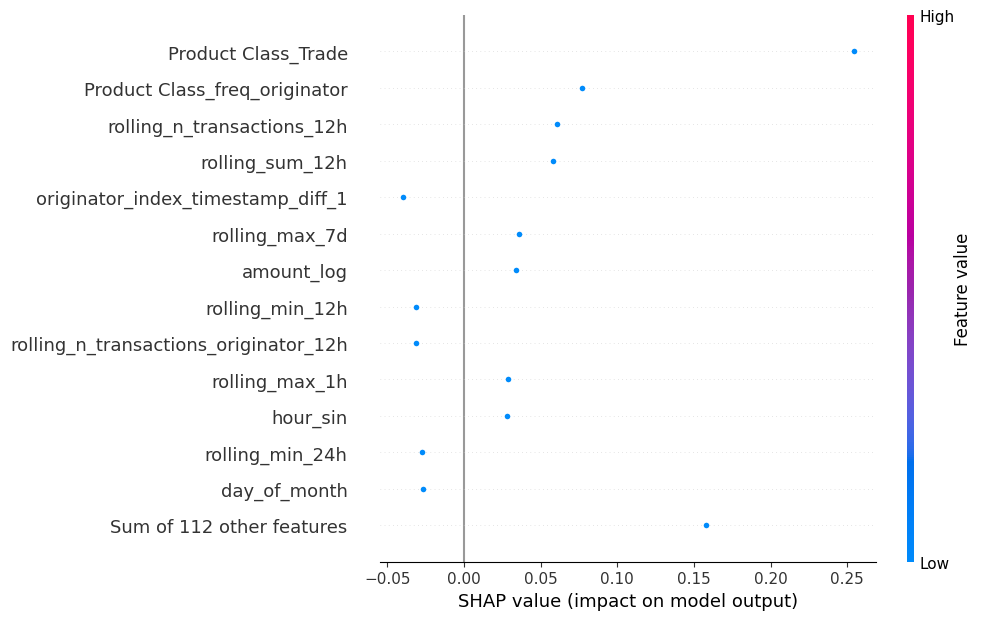

<Figure size 640x480 with 0 Axes>

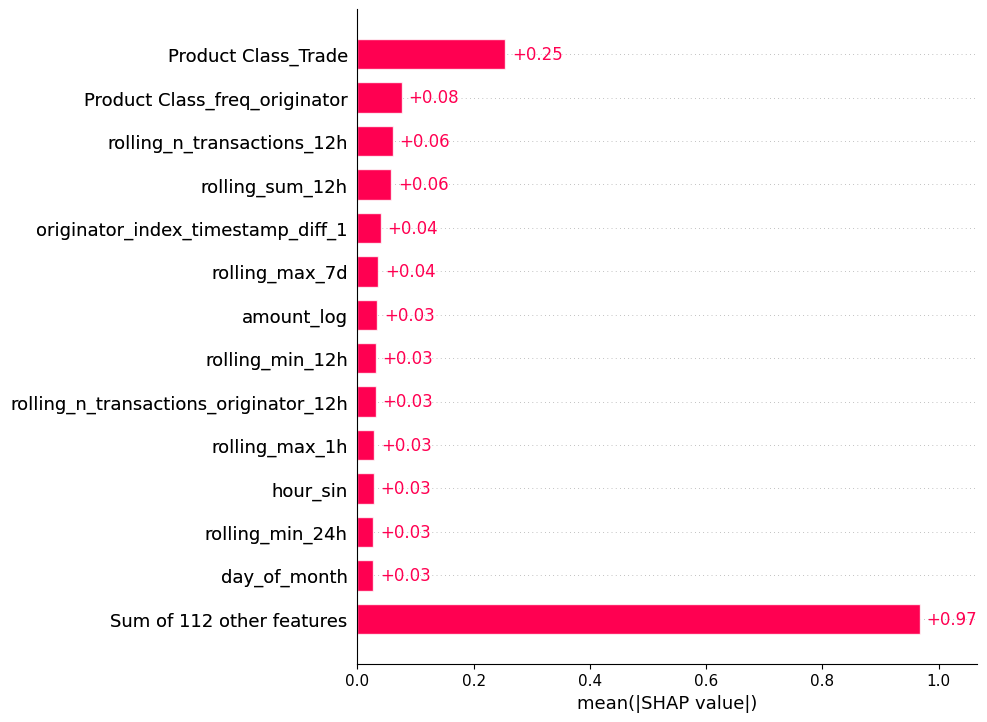

Saved SHAP plots for class 5 to output/shap_plots/
SHAP explanations generated and saved.


In [31]:
get_shap_explanations_mlp_class(model, X_train_shap, X_test[idx].reshape(1, -1), feature_names, filename='figs/shap_plots/shap_amaretto_GM')